# Inference

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from predictor import NUCLEIdemo
from predictor_coco import COCODemo
from PIL import Image
import numpy as np
from maskrcnn_benchmark.config import cfg
import os
import torch
from maskrcnn_benchmark.config.paths_catalog import DatasetCatalog
from maskrcnn_benchmark.utils.imports import import_file

In [2]:
# increasing the size of figures
pylab.rcParams['figure.figsize'] = 17, 17

# path of configs
CONFIGS = '../configs/'

There are multiple models to choose from in order to obtain a prediction. All models can be found in the folder `/data/proj/smFISH/Students/Max_Senftleben/files/models/`. Choosing the model_final.pth in each directory will lead to the best results.
In the following, some examples are provided:

`/data/proj/smFISH/Students/Max_Senftleben/files/models/20190423_transfer_ale/model_final.pth`

originally trained on nuclei from somatosensory cortex cells and then re-trained on 
oligodendrocyte progenitor cells, backbone ResNet 50.

`/data/proj/smFISH/Students/Max_Senftleben/files/models/20190310_offline_augment/model_final.pth`

originally trained on nuclei from somatosensory cortex cells, backbone ResNet 50.

`/data/proj/smFISH/Students/Max_Senftleben/files/models/20190315_poly_t/model_final.pth`

trained on cells from poly-A staining, ResNet 50.

Most models were trained with a learning rate of 0.0025 which was found to be best. Information about the training process of each model can be found in the folder in the `log.txt` file with `head -100 log.txt`.

In [3]:
# load config file

config_file = CONFIGS + 'poly_t_1gpu_nonorm.yaml'
cfg.merge_from_file(config_file)
cfg.merge_from_list(['MODEL.DEVICE', 'cpu'])

# change dimensions of test images
cfg.merge_from_list(['INPUT.MAX_SIZE_TEST','1028'])

# change normalization, here model was not normalized
cfg.merge_from_list(['INPUT.PIXEL_MEAN', [0., 0., 0.]])

# define model to use here
cfg.merge_from_list(['OUTPUT_DIR', '.'])
cfg.merge_from_list(['MODEL.WEIGHT', '/data/proj/smFISH/Students/Max_Senftleben/files/models/20190315_poly_t/model_final.pth'])


In [4]:
# set the model loader, for nuclei do NUCLEIdemo
nuclei_detect = NUCLEIdemo(
    cfg,
    min_image_size = 512,
    confidence_threshold=0.2,
    show_mask_heatmaps = False
)

# pass categories (nuclei)
nuclei_cat = [
        "__background",
        "nuclei",
        "undefined",
        "clusters"]

# pass categories (poly-t)
poly_cat = [
        "__background",
        "Cell",
        "Undefined",
        "Clusters",
        "Junk"]

categories_to_pass = nuclei_cat
nuclei_detect.CATEGORIES = categories_to_pass
color_rgb_nuclei = [[255,101,80], [0, 255, 0], [0, 255, 255], [0, 0, 255]]
# green is nuclei, turqoise is undefined and blue is cluster predicted
# ground truth is red nuclei, orange undefined and yellow cluster

color_rgb_polyt = [[255,101,80], [0, 255, 0], [0, 0, 255], [0, 255, 255]]
# green is cell, turqoise is cluster and blue is undefined! has to be changed, mix up while annotation I think
# again ground truth is red for cell, orange undefined and yellow cluster

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


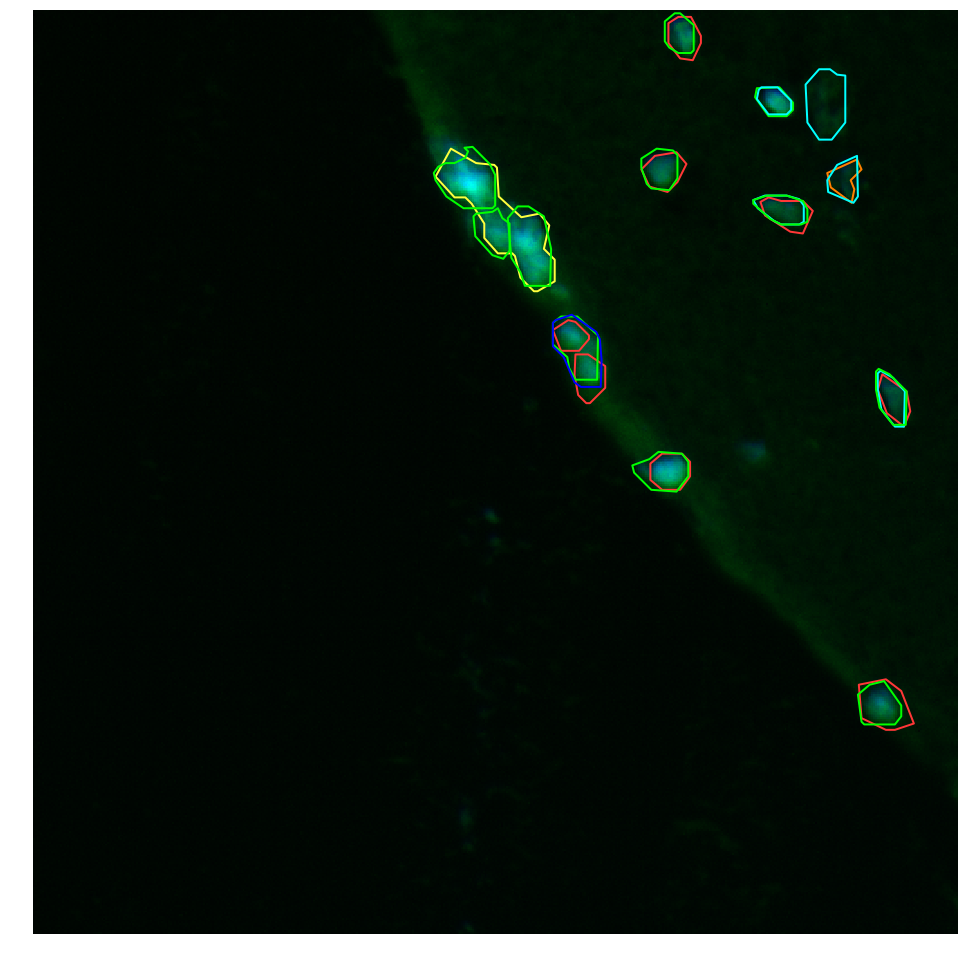

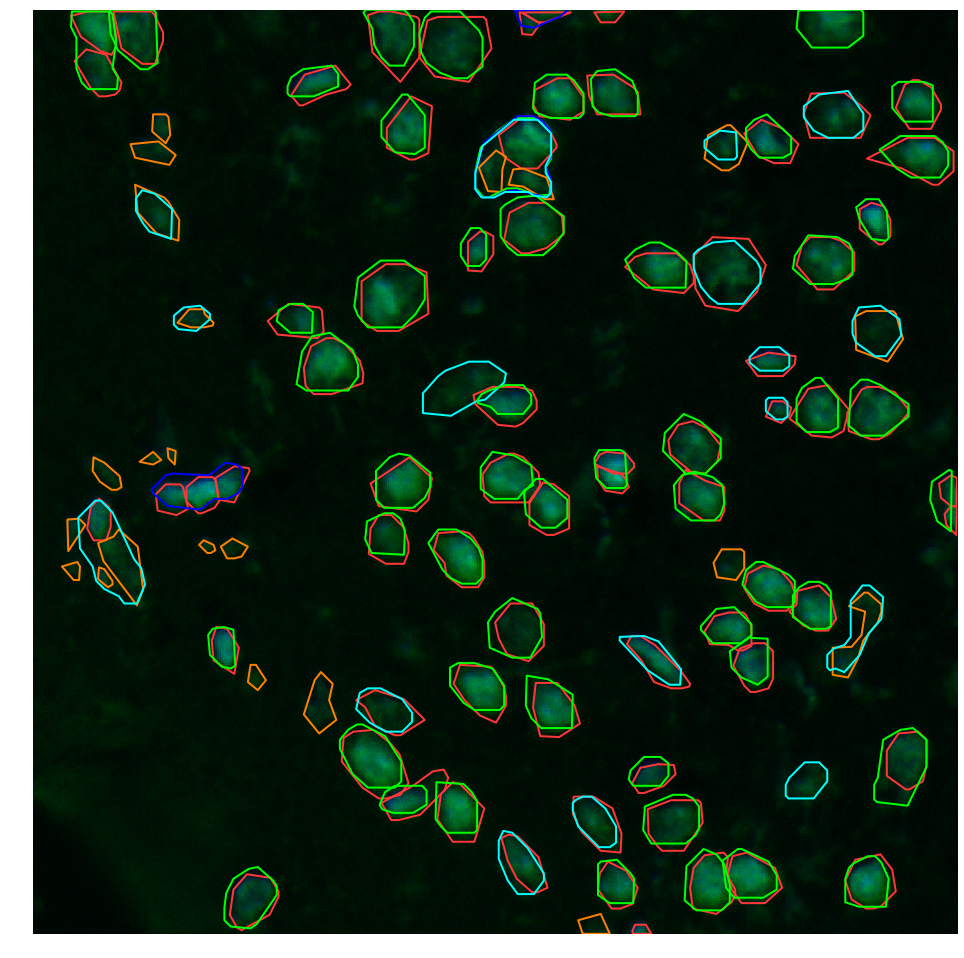

Attribute Error raised


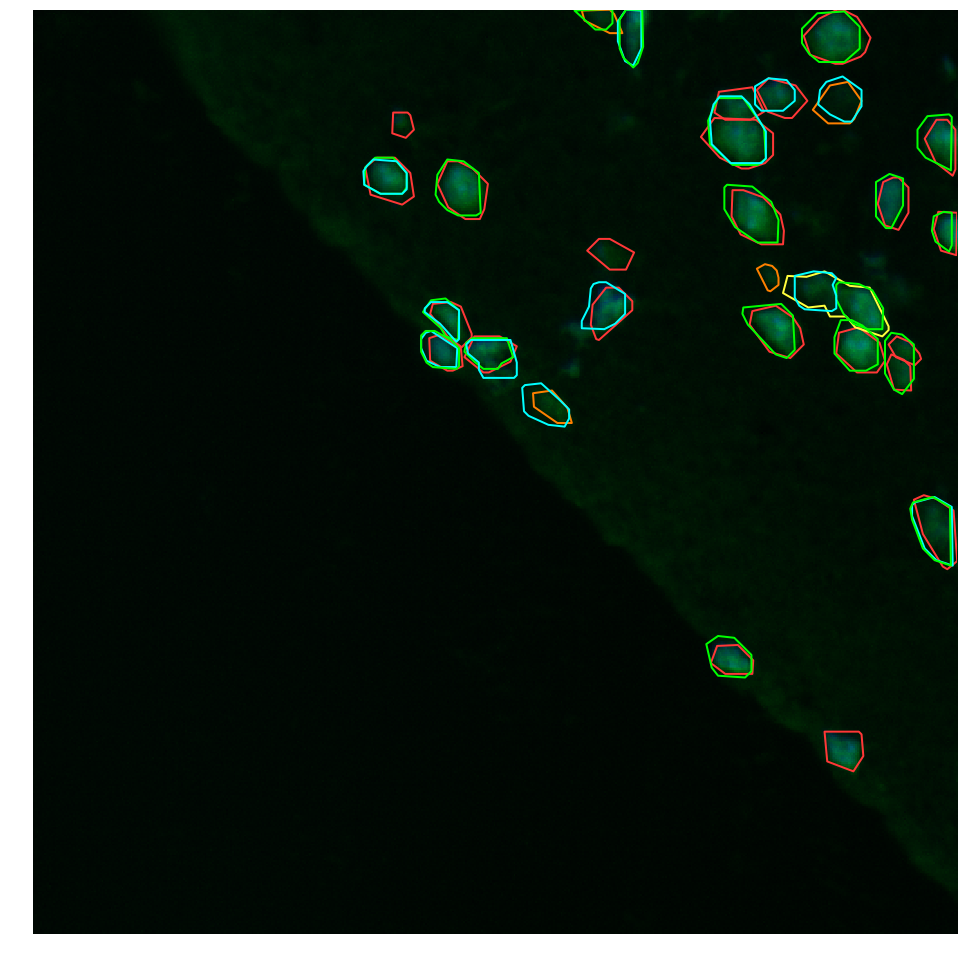

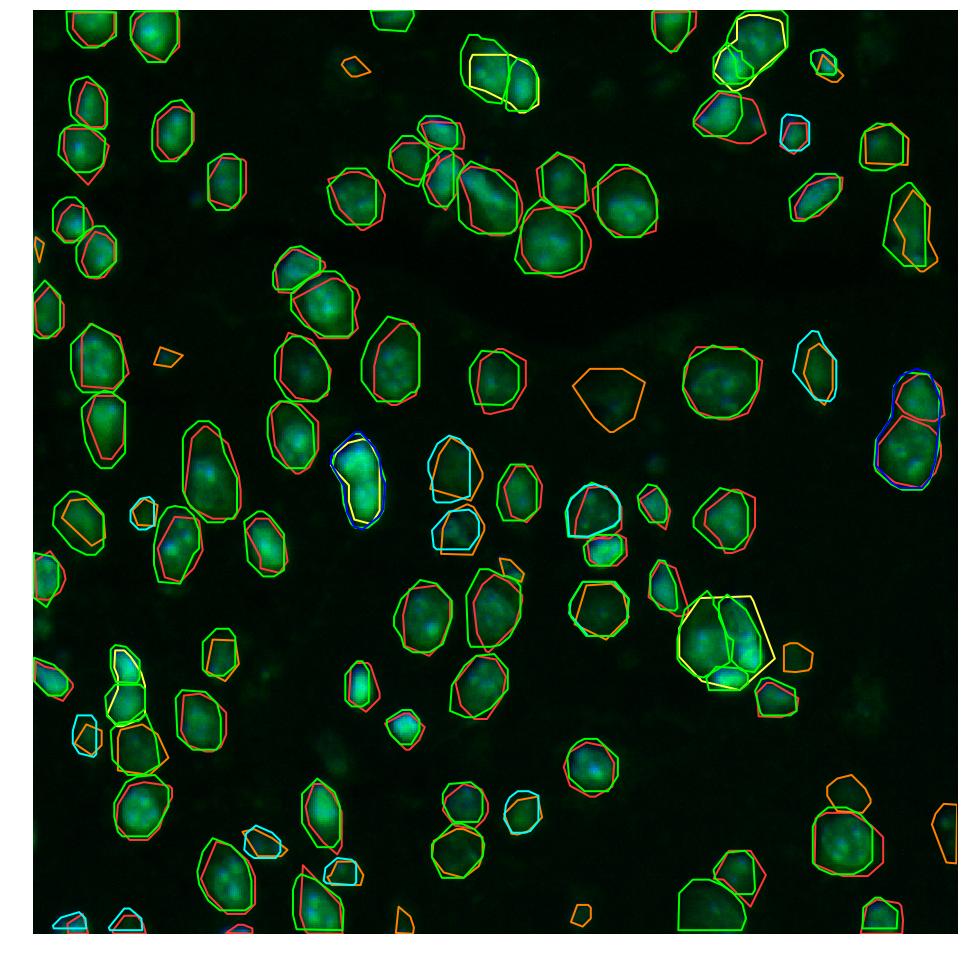

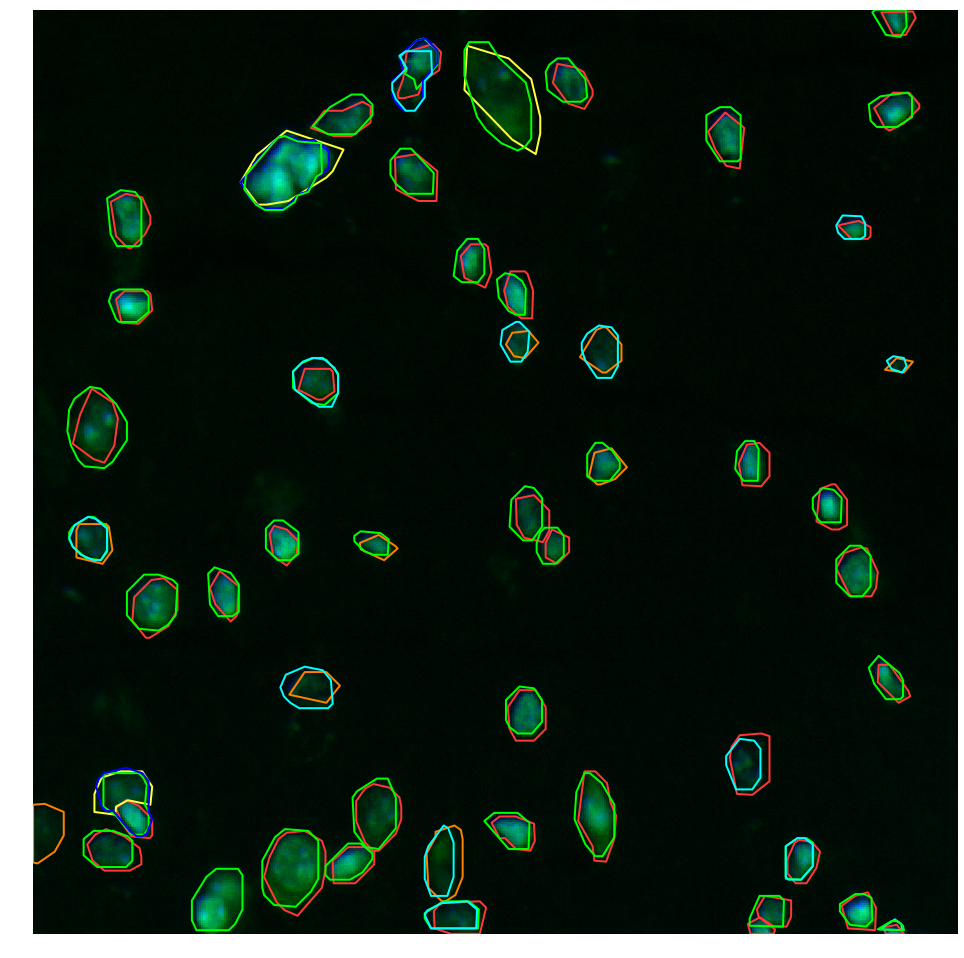

Attribute Error raised


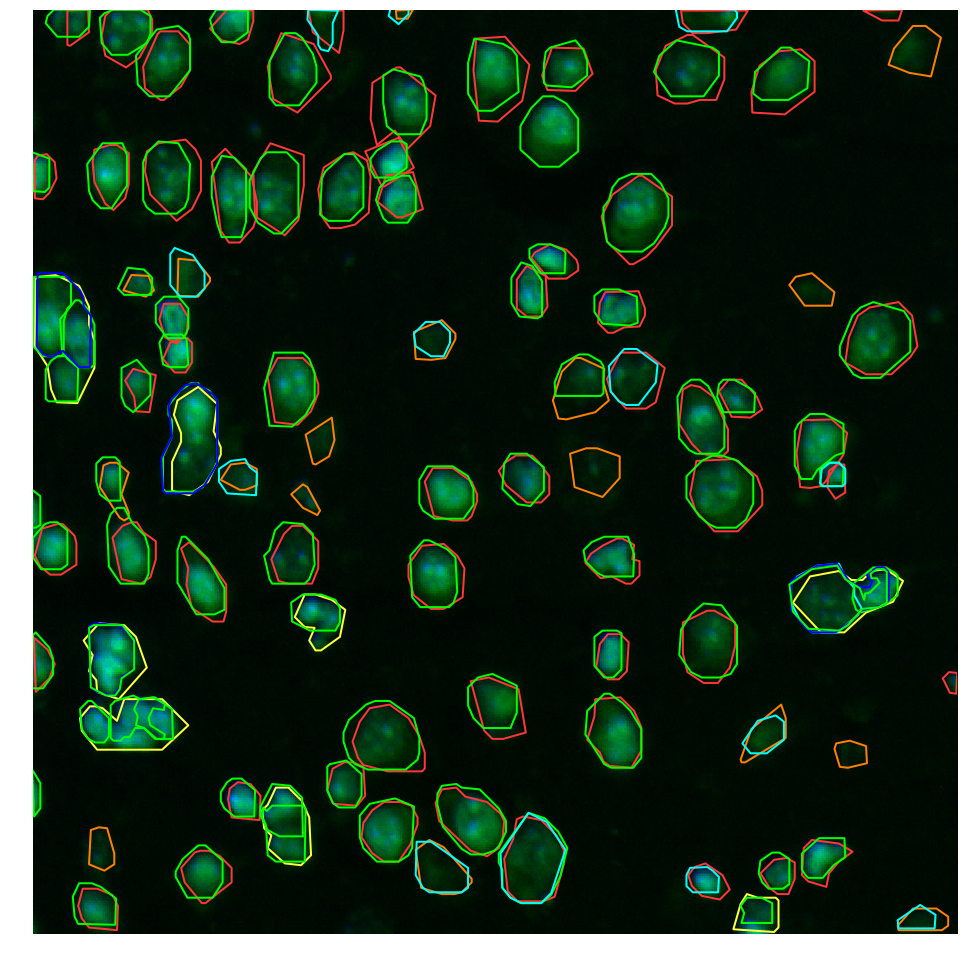

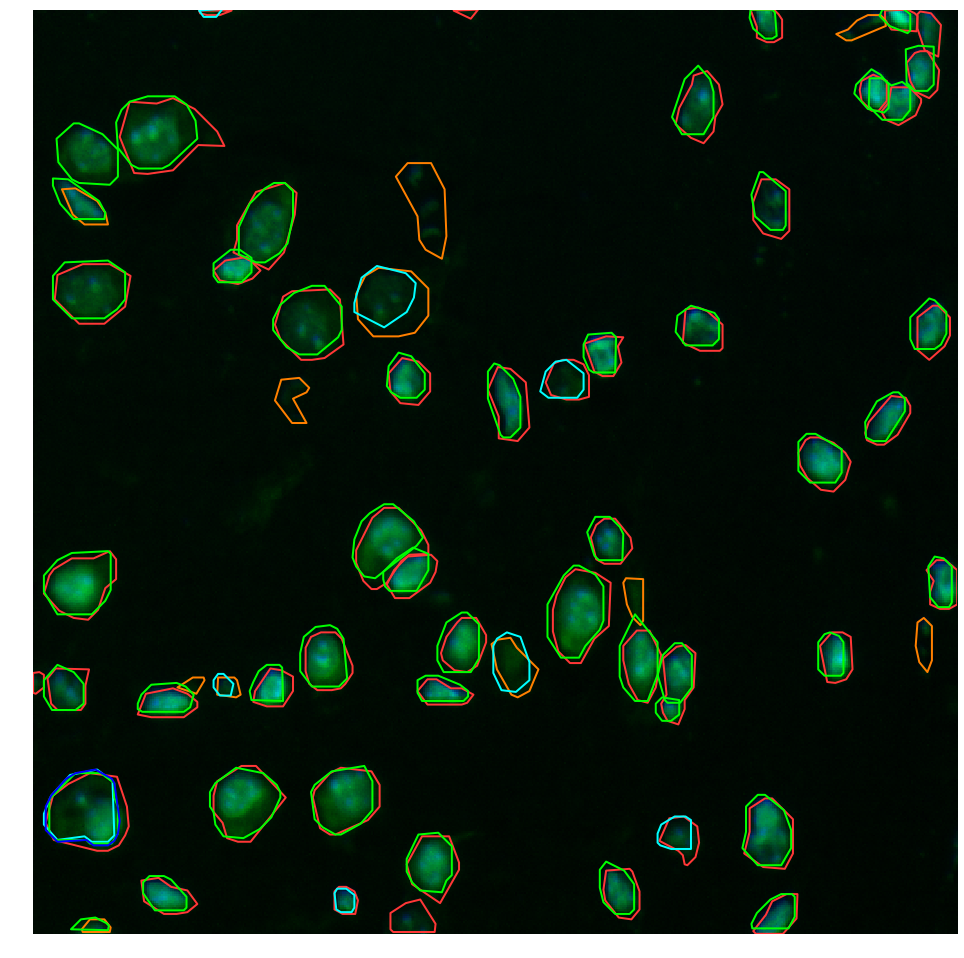

Attribute Error raised


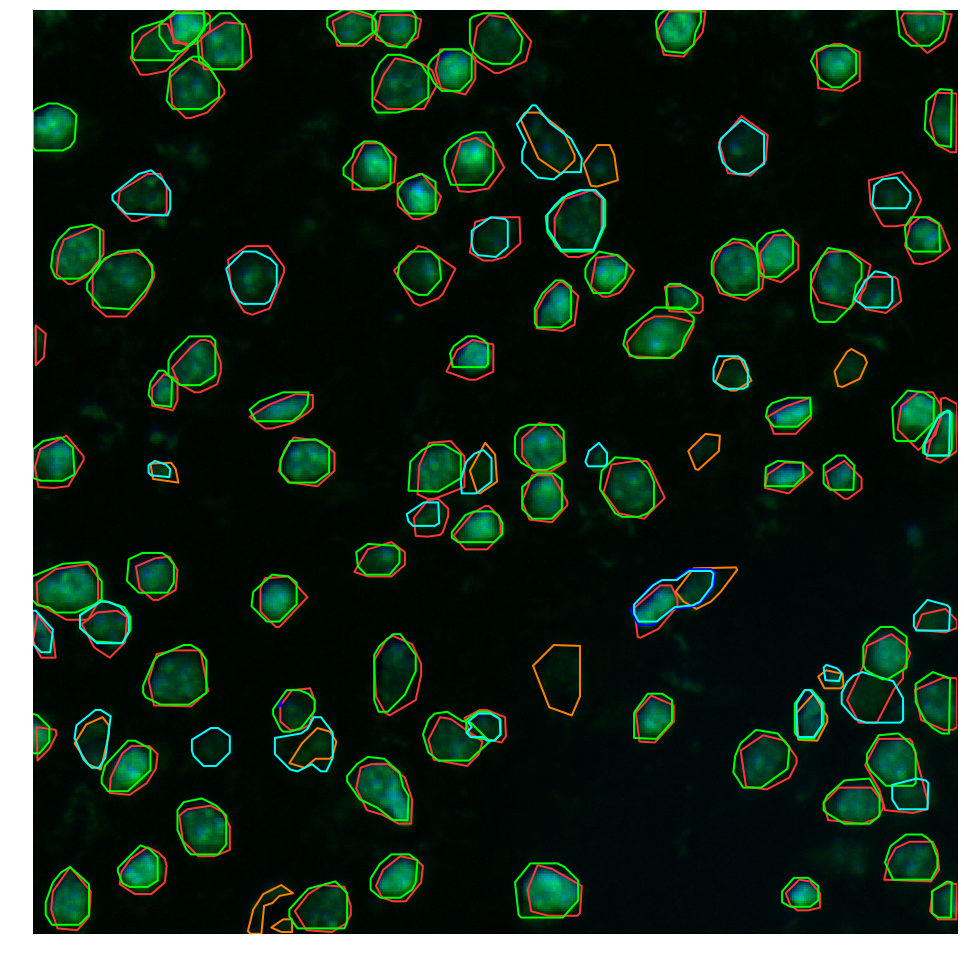

Attribute Error raised
Attribute Error raised


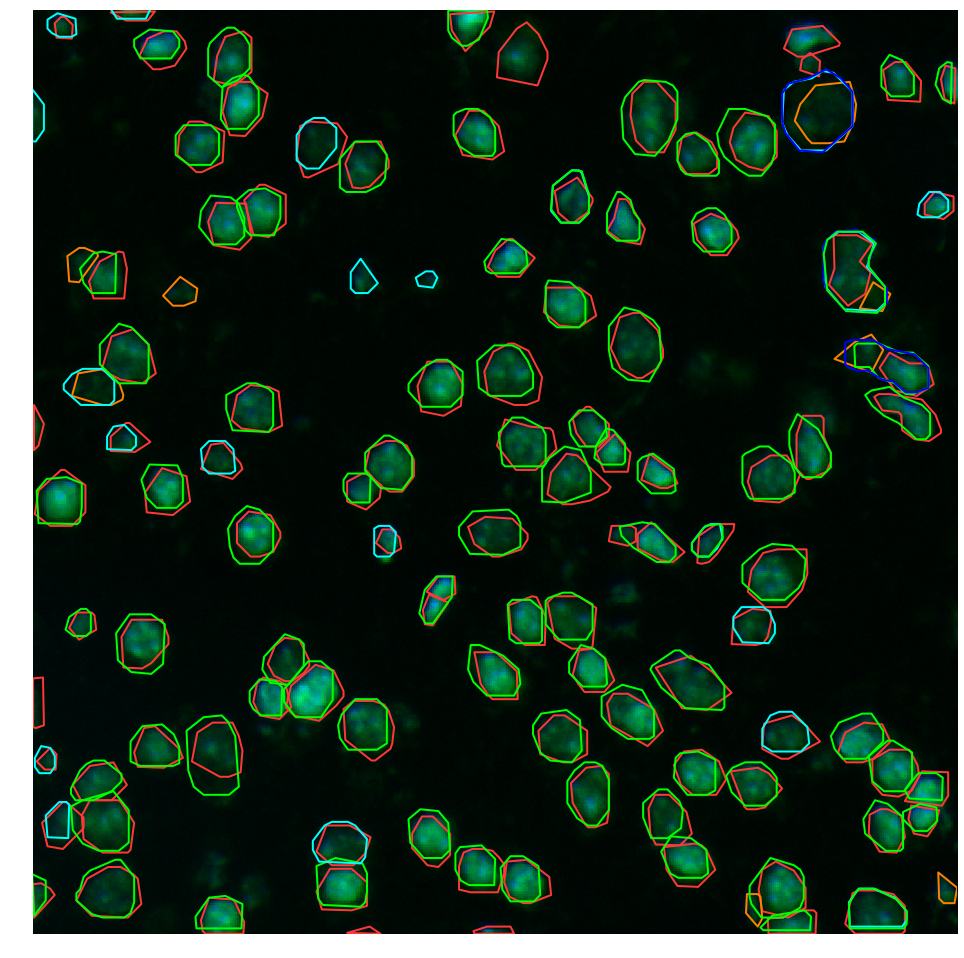

In [5]:
# returns a subplot with predictions (green) vs ground truth (red) of the boxes and masks
# saves the images to the folder in save_path
# the variable predictions contains the confidence scores
# the result images can be saved with specifying save_independently 
predictions = nuclei_detect.inference(color_rgb_polyt, add_class_names = None, save_path = '/home/max/mrcnn_b_work/folder_to_send/infere_nucl/')#, show_ground_truth = False)
                                     #save_independently = '/data/proj/smFISH/Students/Max_Senftleben/files/results/inference_polyt_535000_r152/')


In [9]:
# crop image, because they are saved in a weird way
from PIL import Image

import cv2

margin = 300
def crop(result_path):
    
    for image in os.listdir(result_path):
        if not image.endswith("_hist.png"):

            original = Image.open(result_path + image)
            
            #original.show()

            width, height = original.size   # Get dimensions
            
            
            
            left = (width-height)/2
            top = 0
            right = height + ((width-height)/2)
            bottom = height
            cropped_example = original.crop((left, top, right, bottom))

            cropped_example.save(result_path + image)
            
            
result_path = '/data/proj/smFISH/Students/Max_Senftleben/files/results/inference_nuclei_r50_442500/'
result_path = '/data/proj/smFISH/Students/Max_Senftleben/files/results/inference_polyt_535000_r152/'
crop(result_path)

In [11]:
import random

# create histogram for confidence
def histogram(image_name, scores, labels, save_path = None):
    
    # get scores
    all_scores = []
    set_labels = sorted(set(labels))
    for i in set_labels:
        temp = []
        for s in range(len(scores)):
            if labels[s] == i:
                temp.append(scores[s])
        all_scores.append(temp)
    
    # make plot
    
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    bins = np.linspace(0, 1, 100)
    for c, category in enumerate(all_scores):
        plt.hist(category, bins, alpha = 1, 
                 label = 'Number of {}: {}'.format(list(set_labels)[c], len(category)))
    plt.legend(loc = 'upper left')
    plt.title('Frequency distribution confidence for {}'.format(image_name))
    
    if save_path:
        plt.savefig(save_path + image_name[:-4] + '_hist.png')
    plt.show()
        

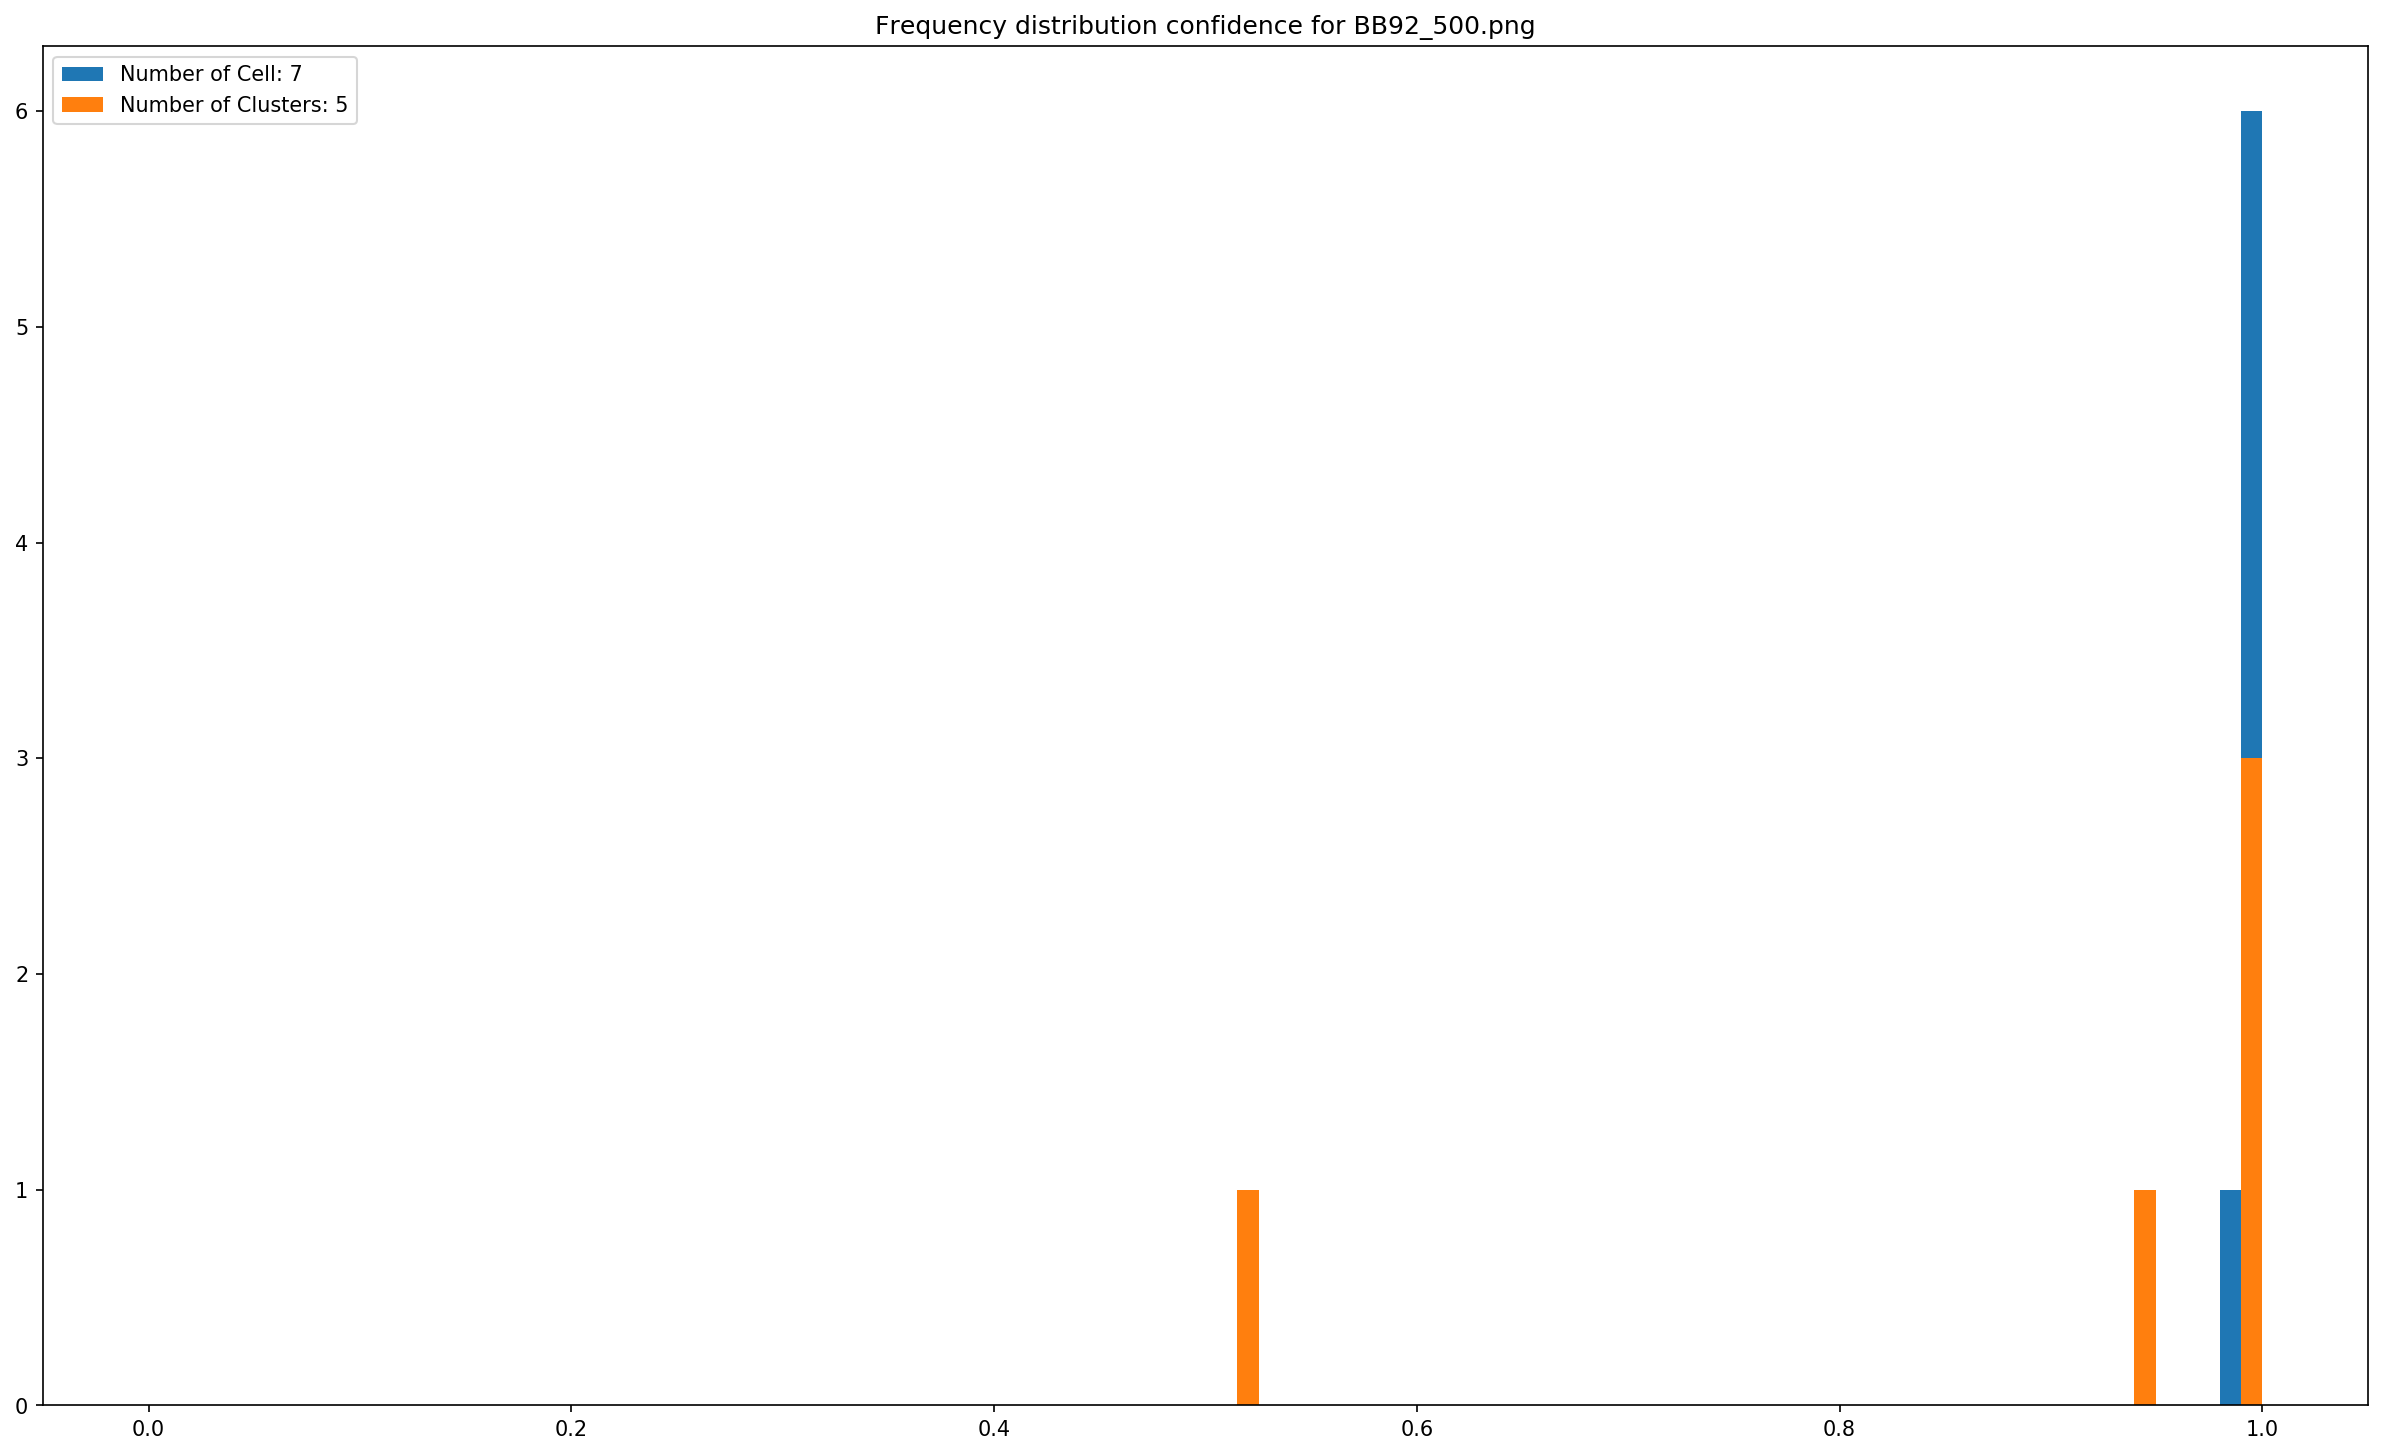

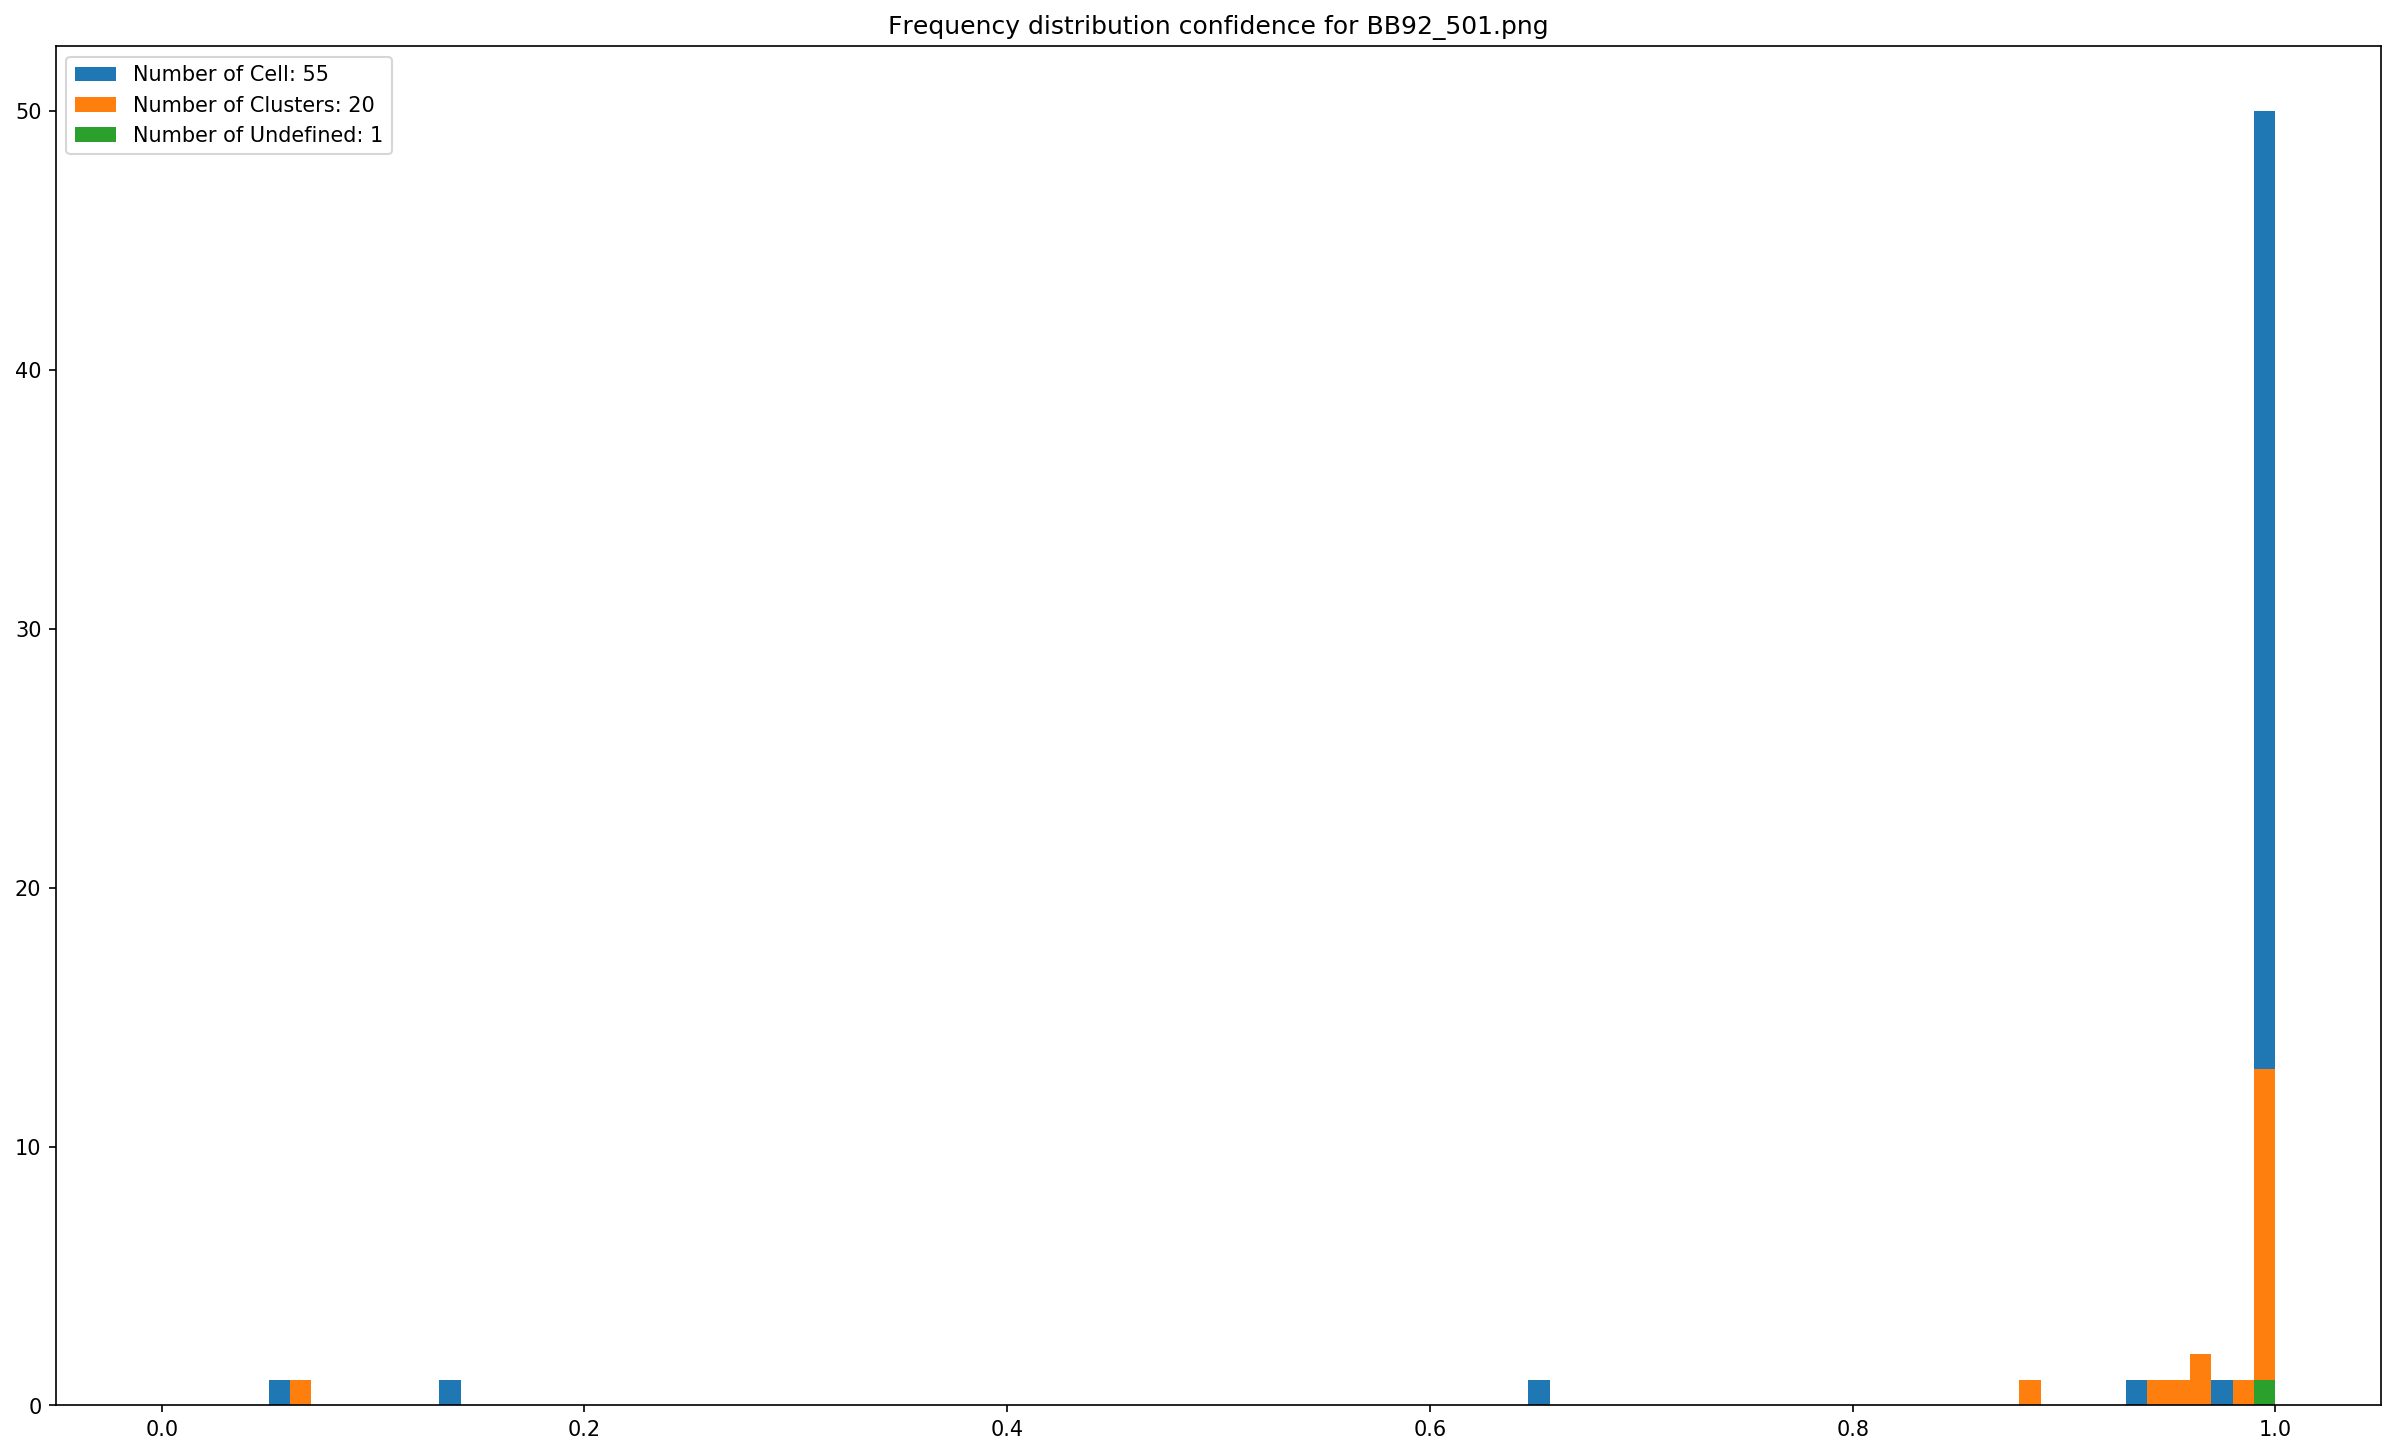

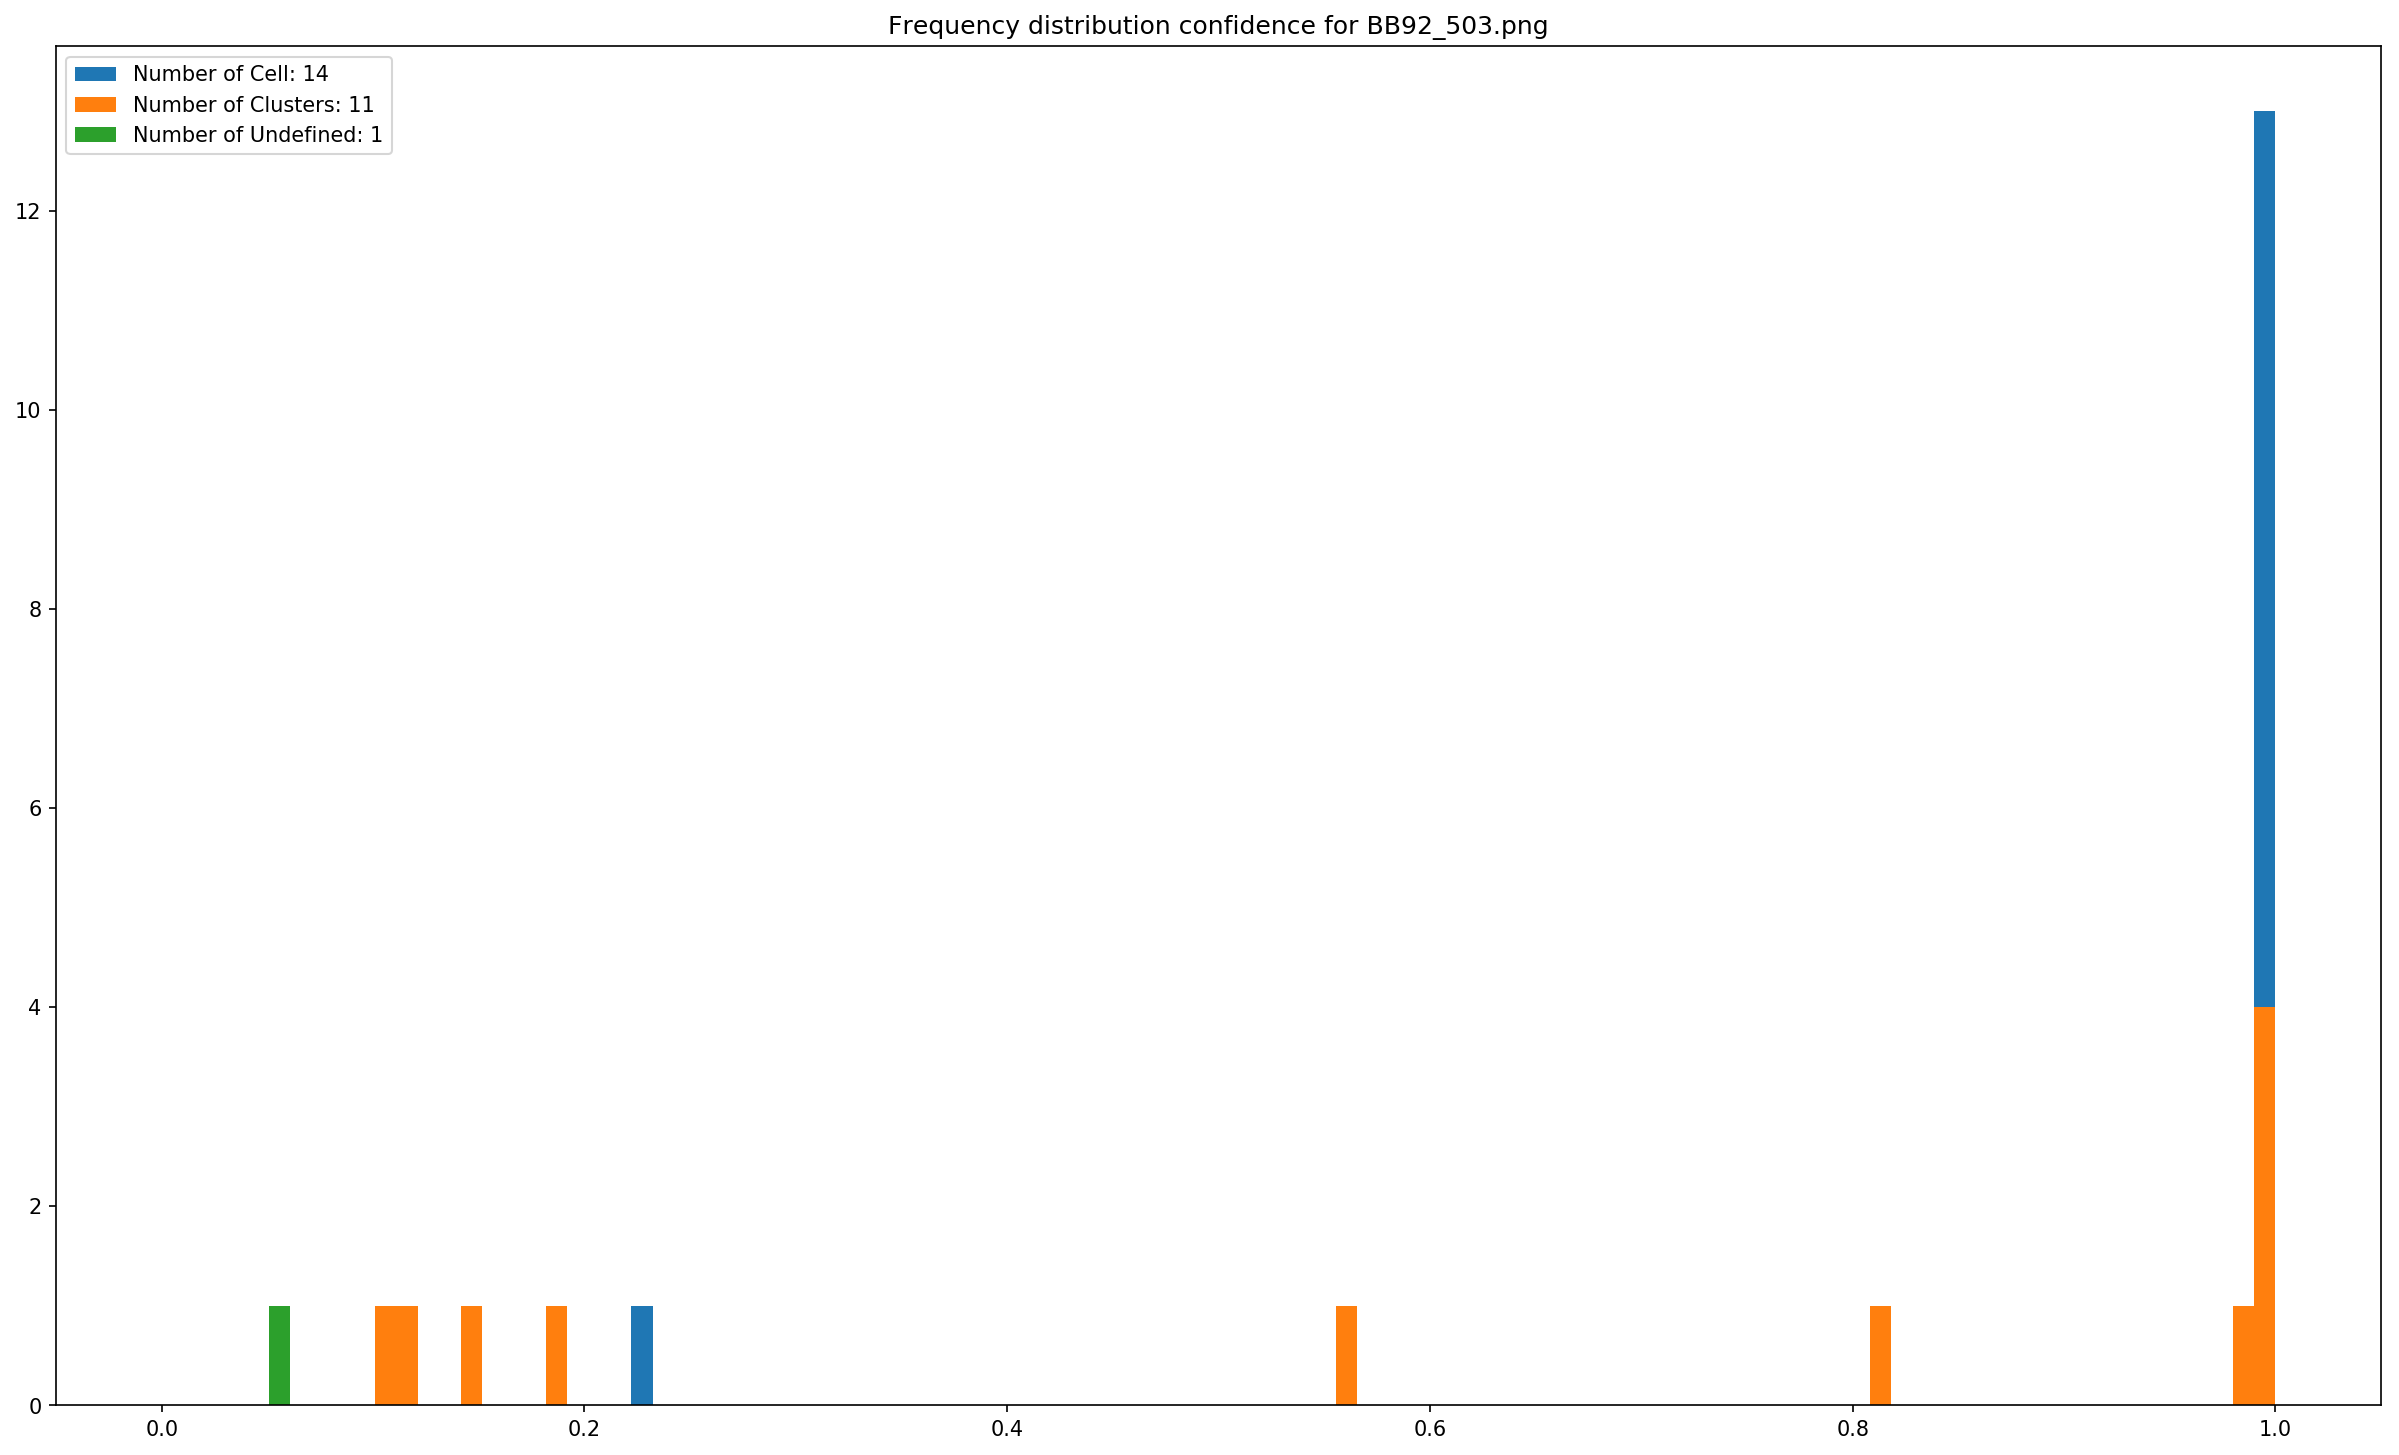

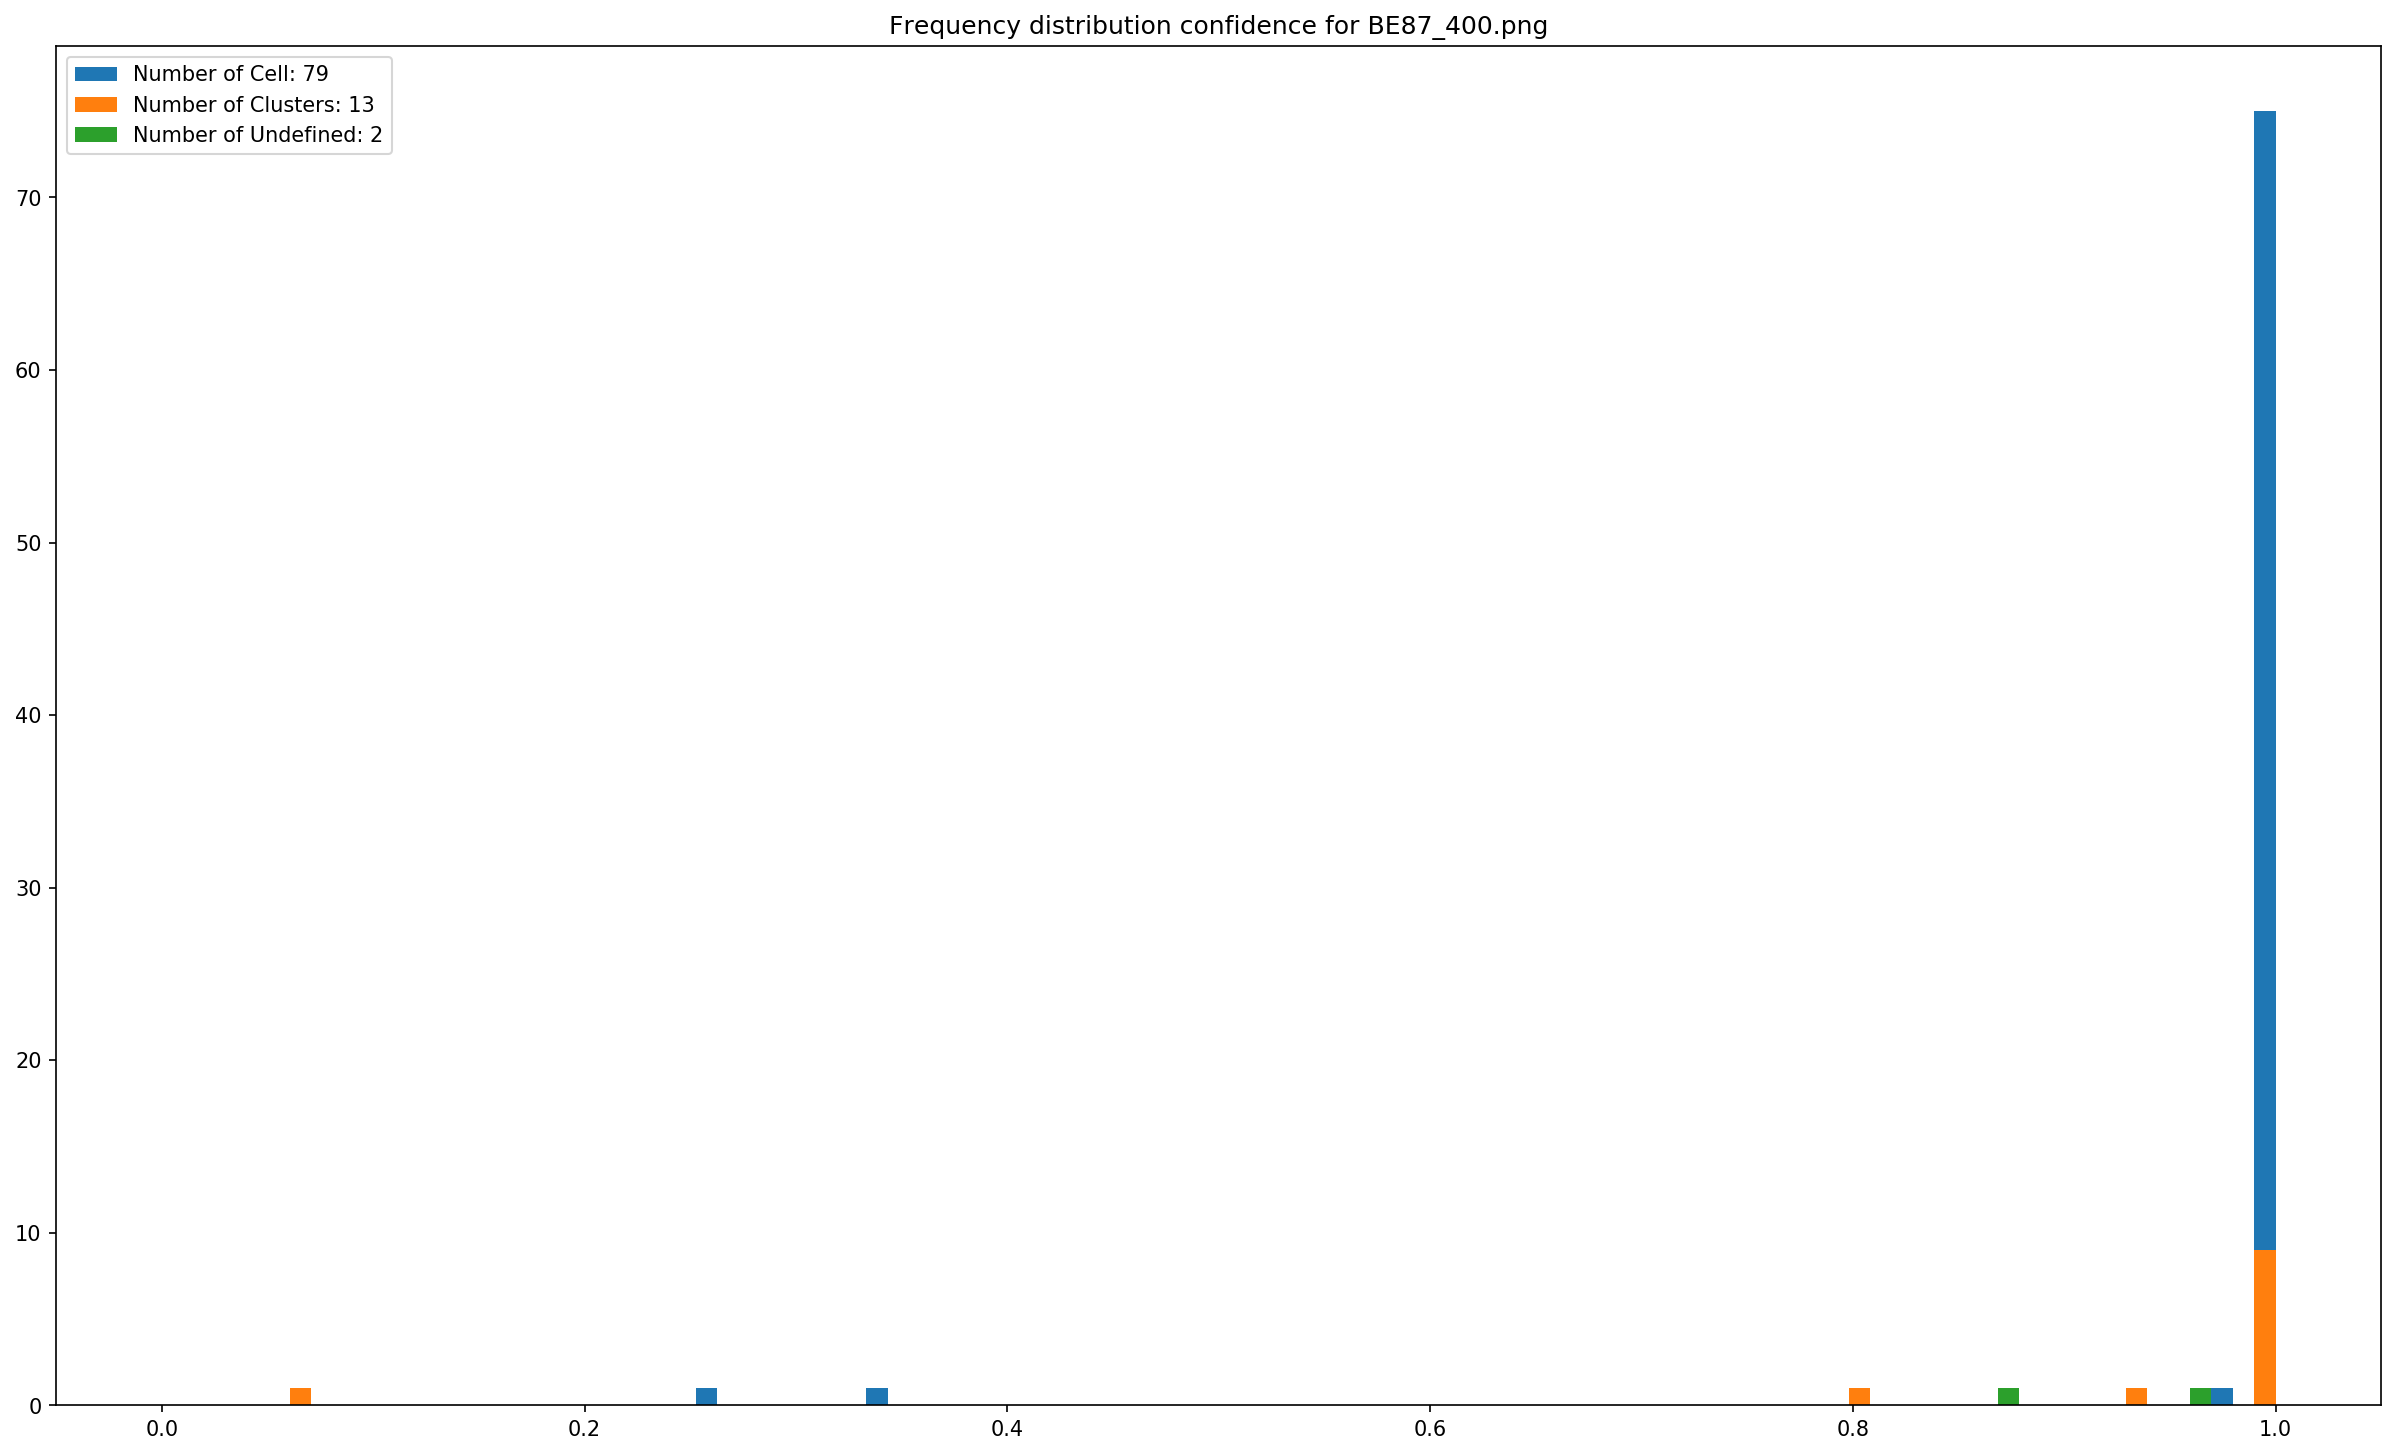

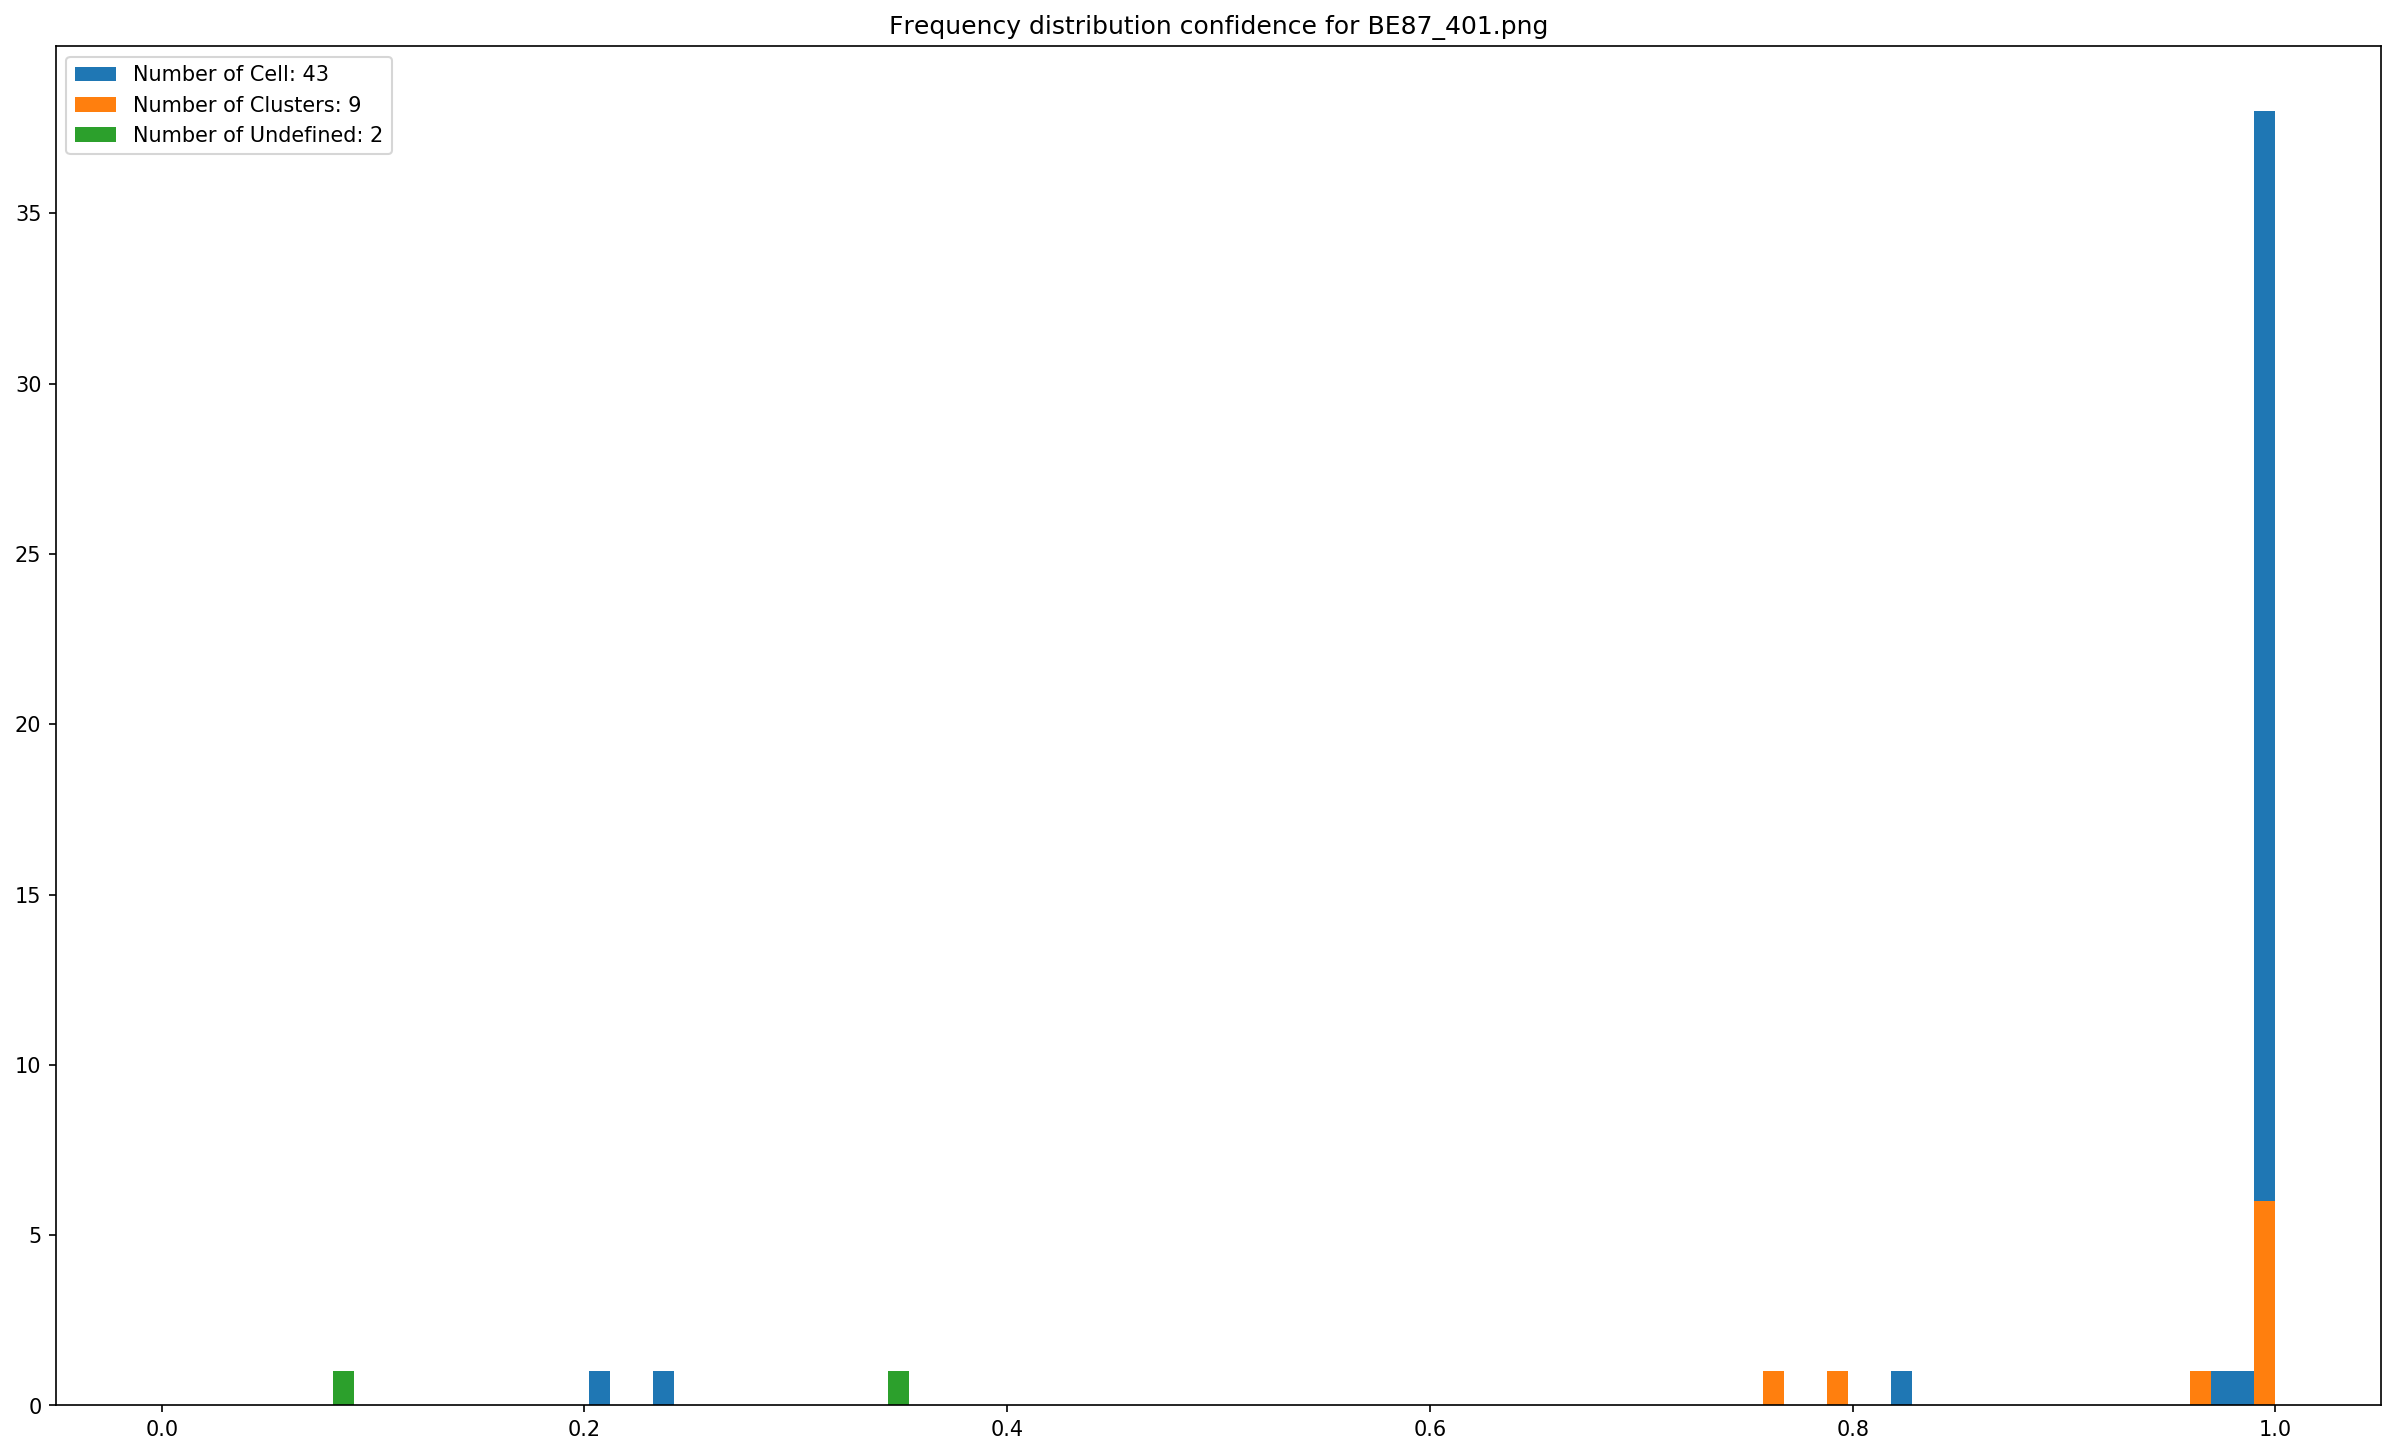

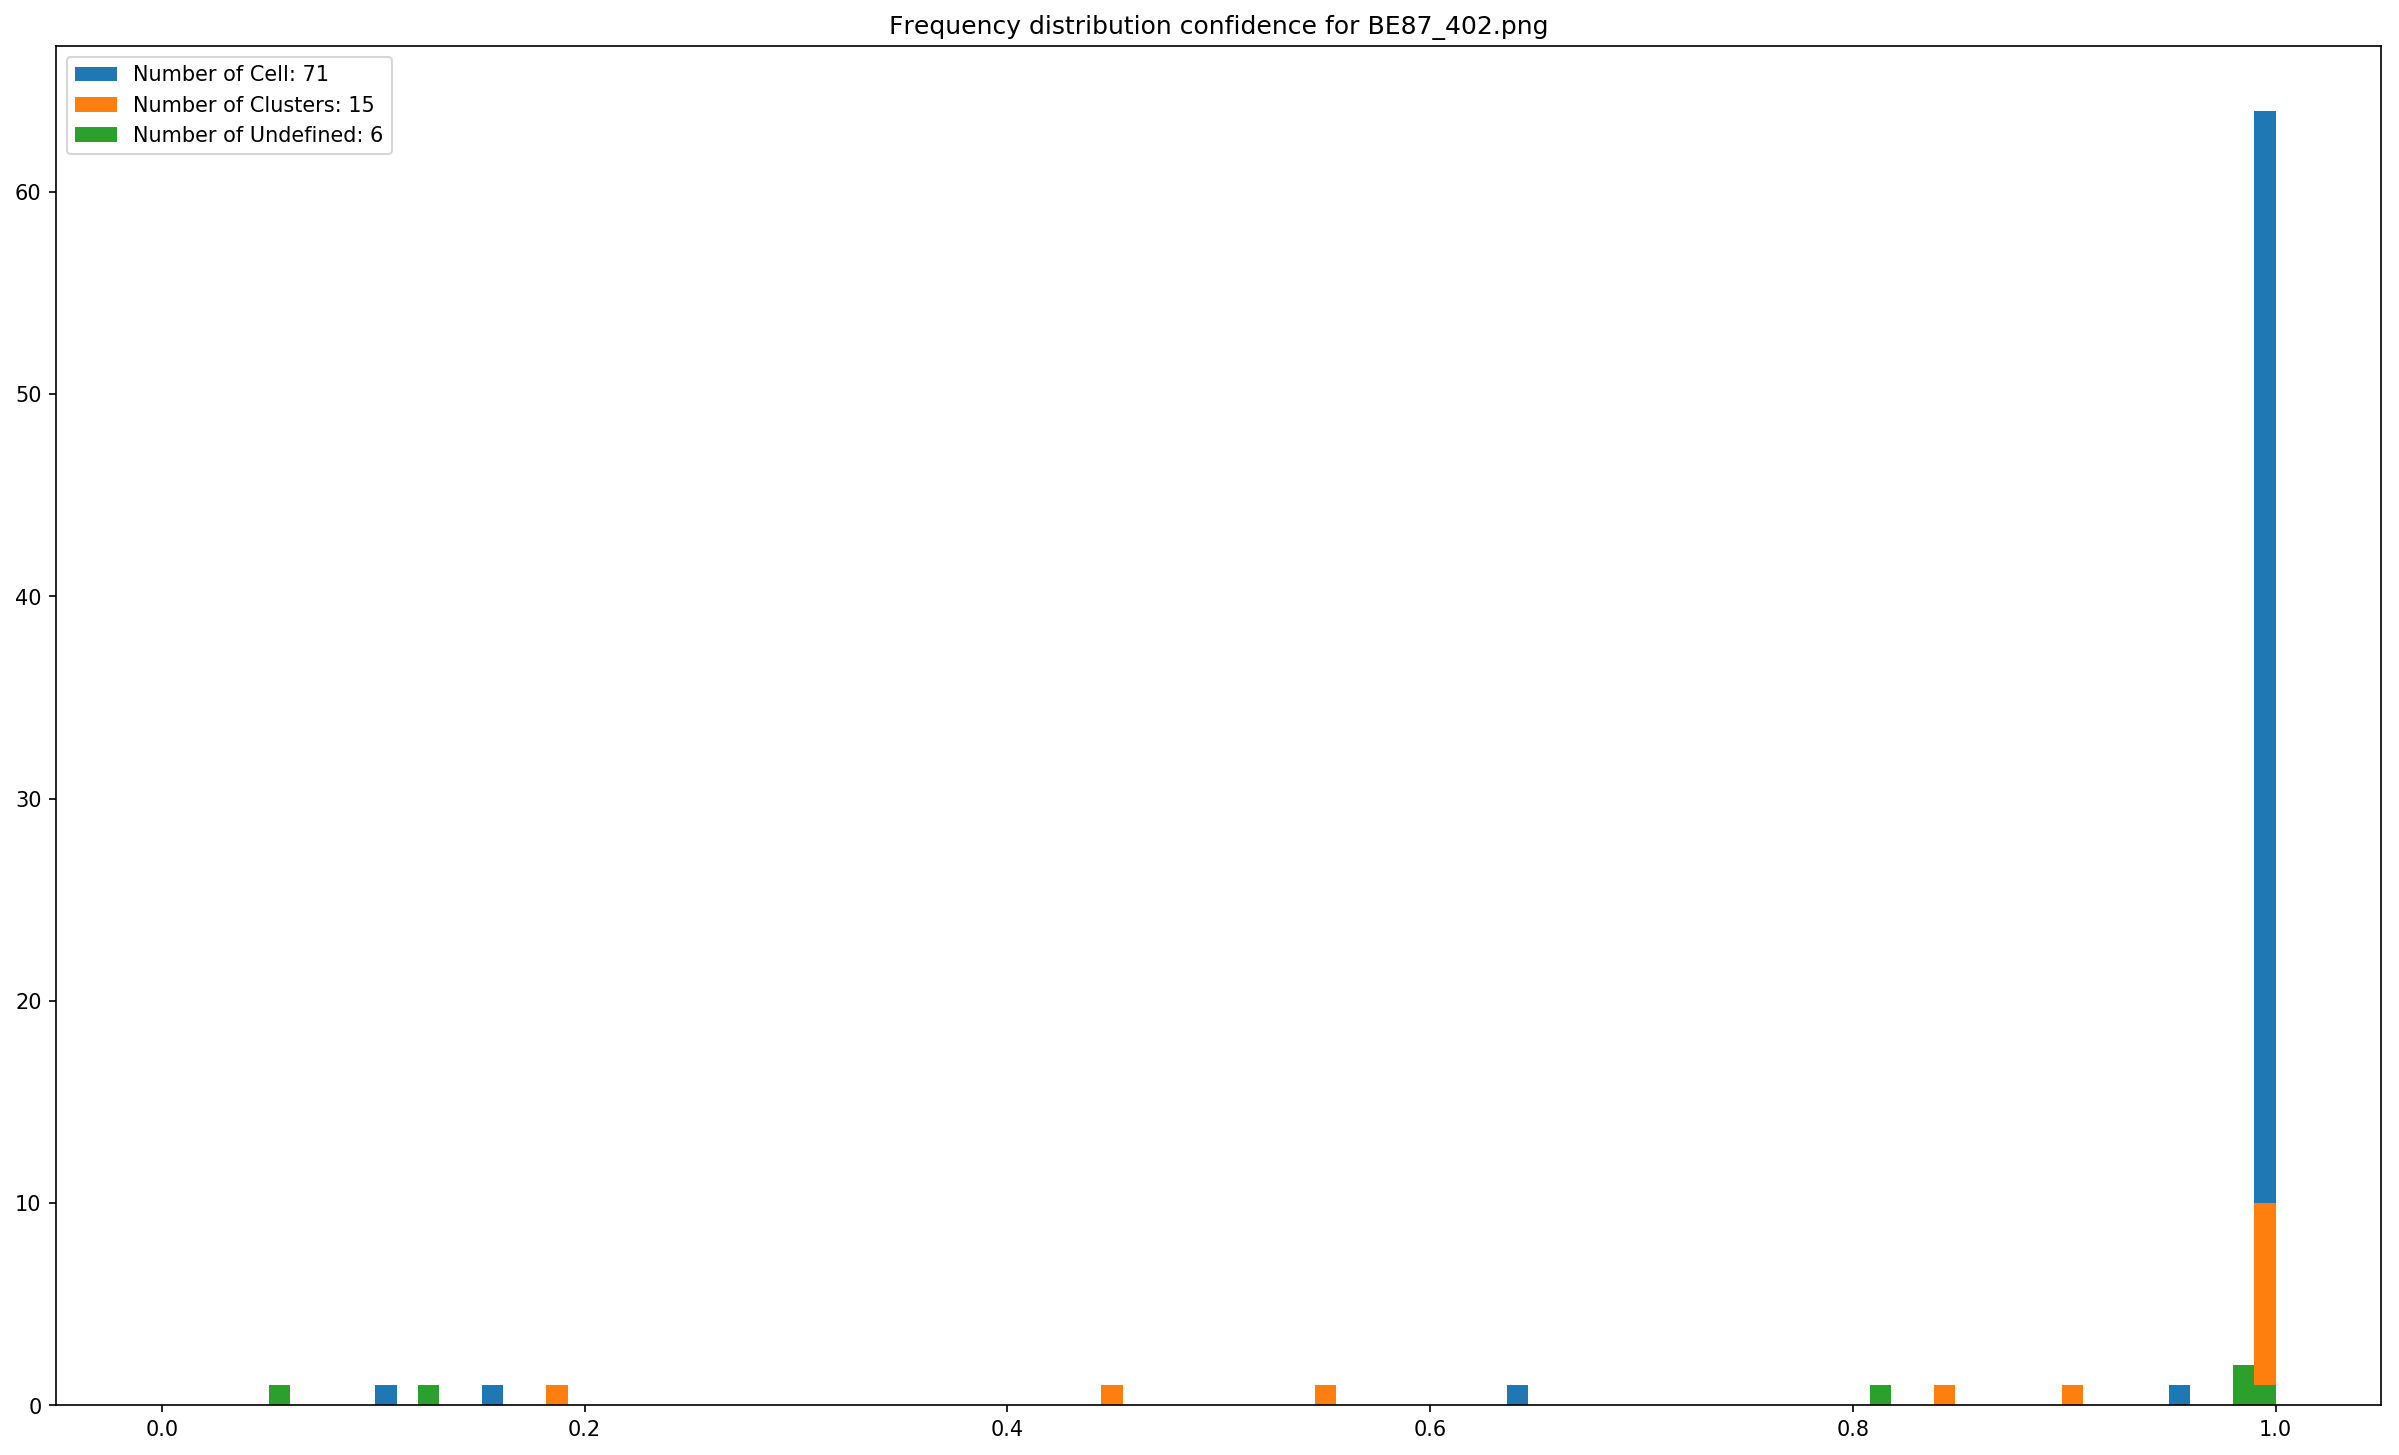

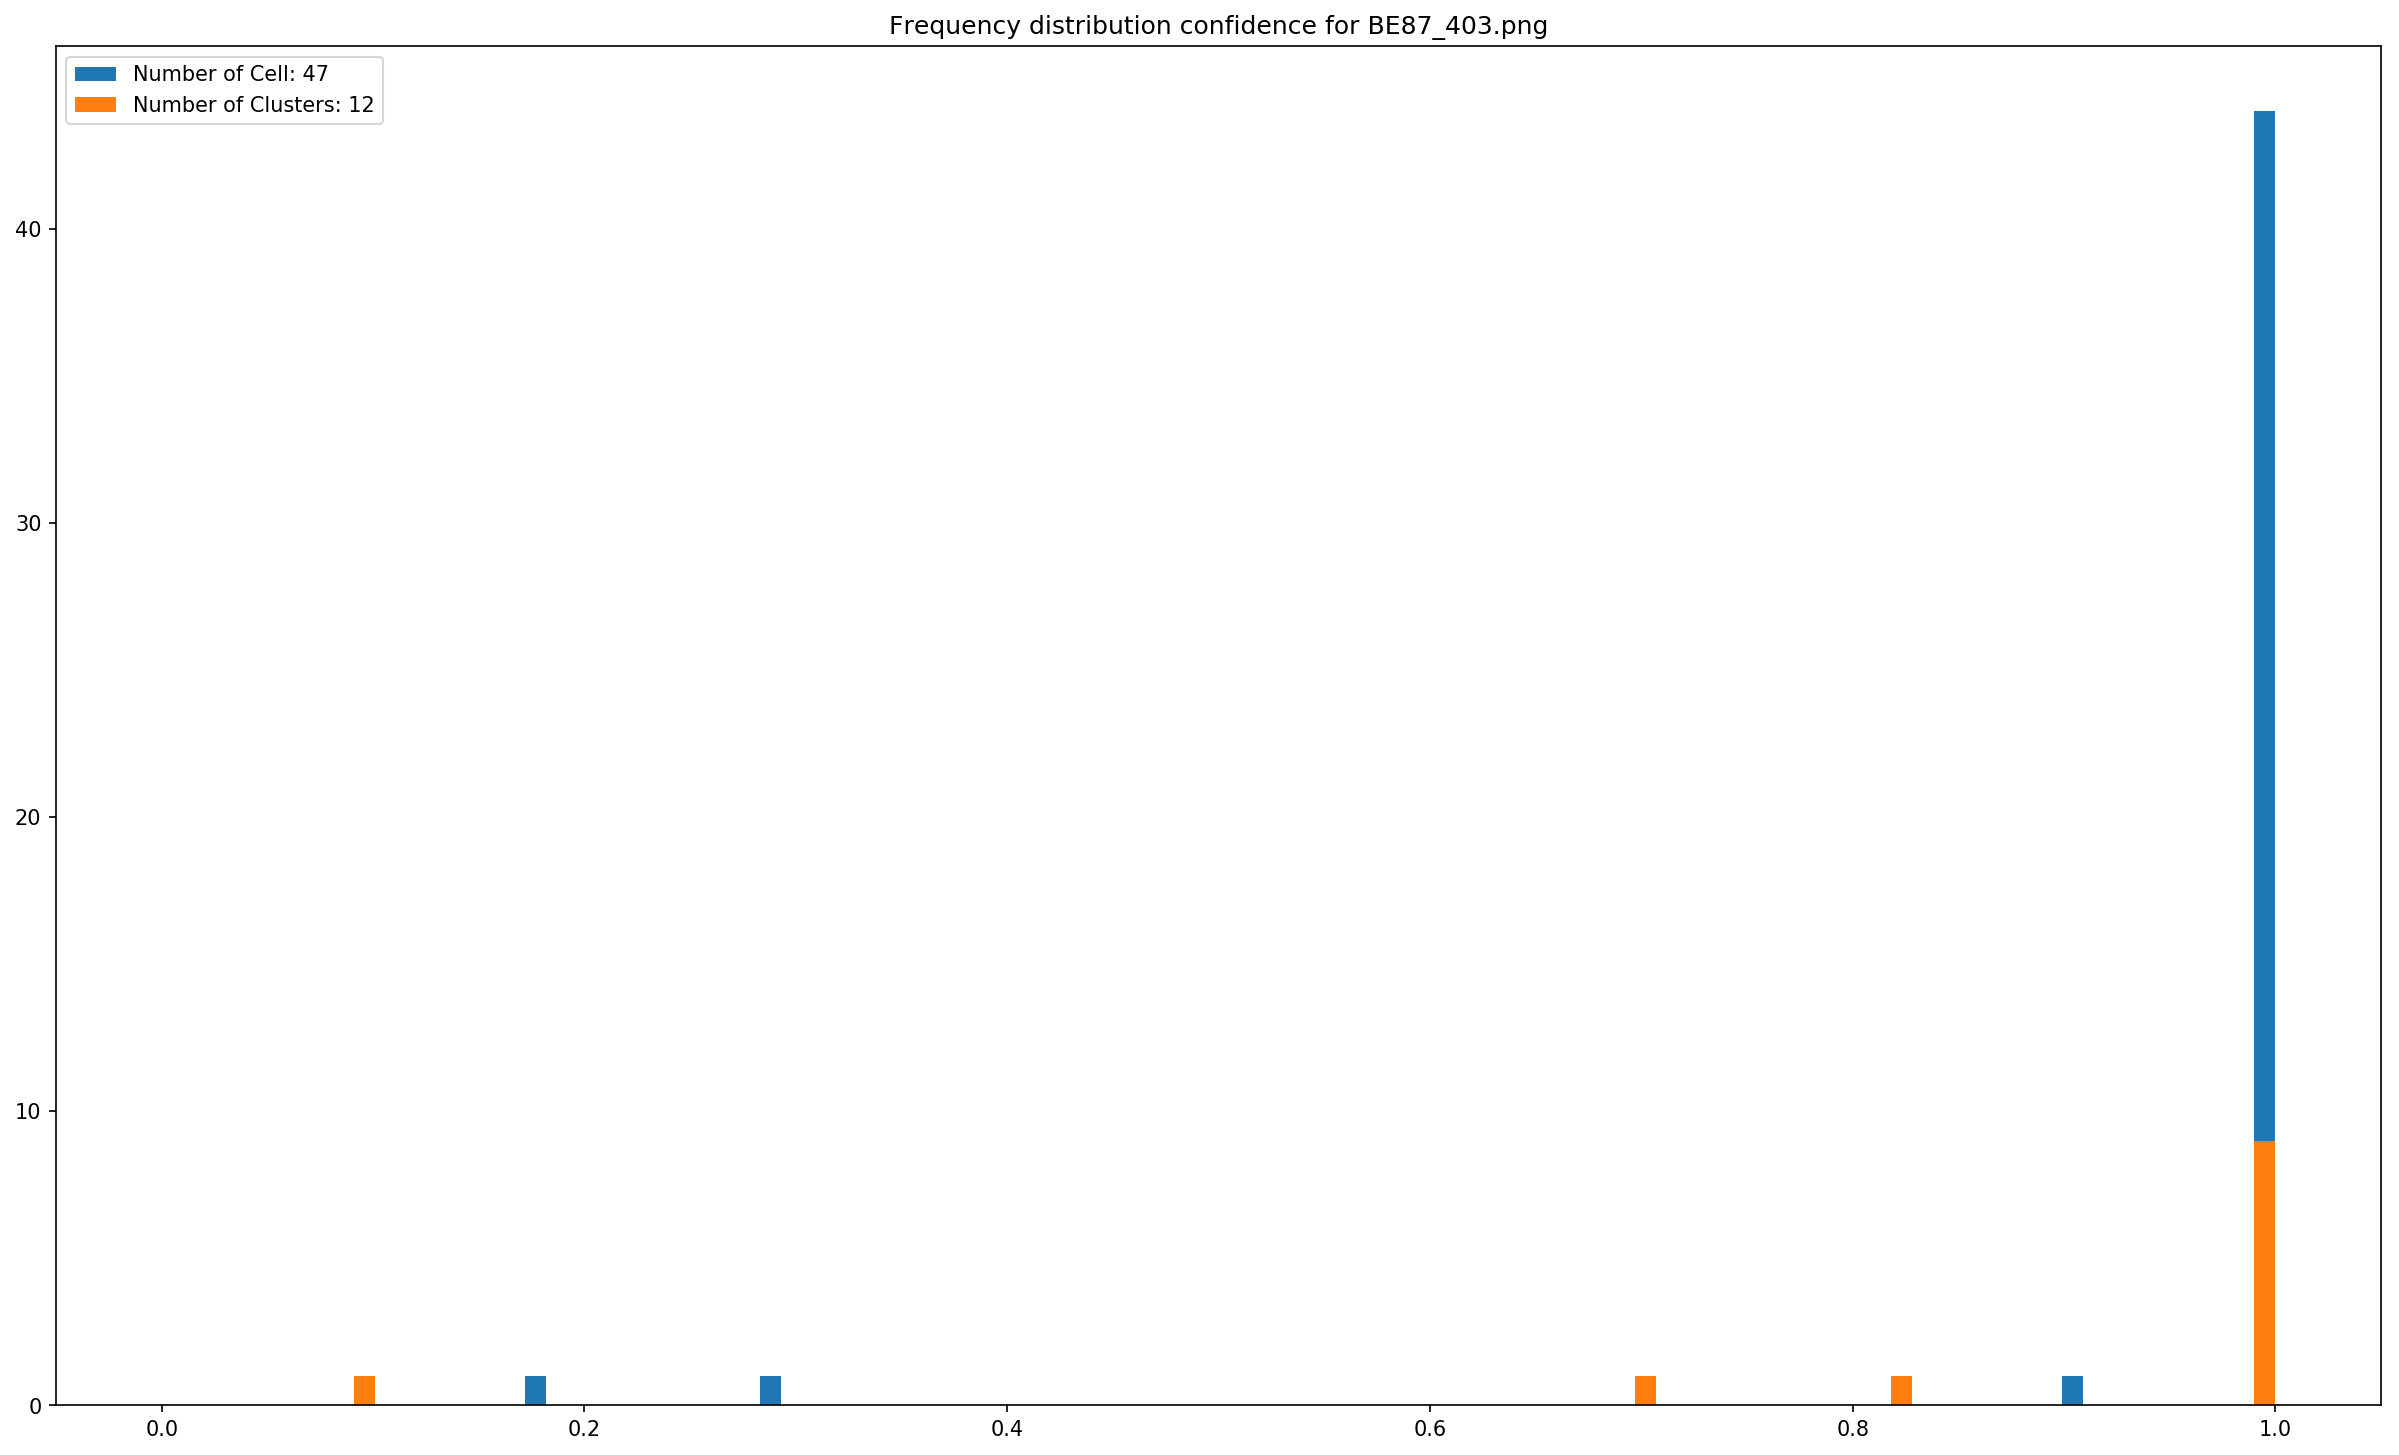

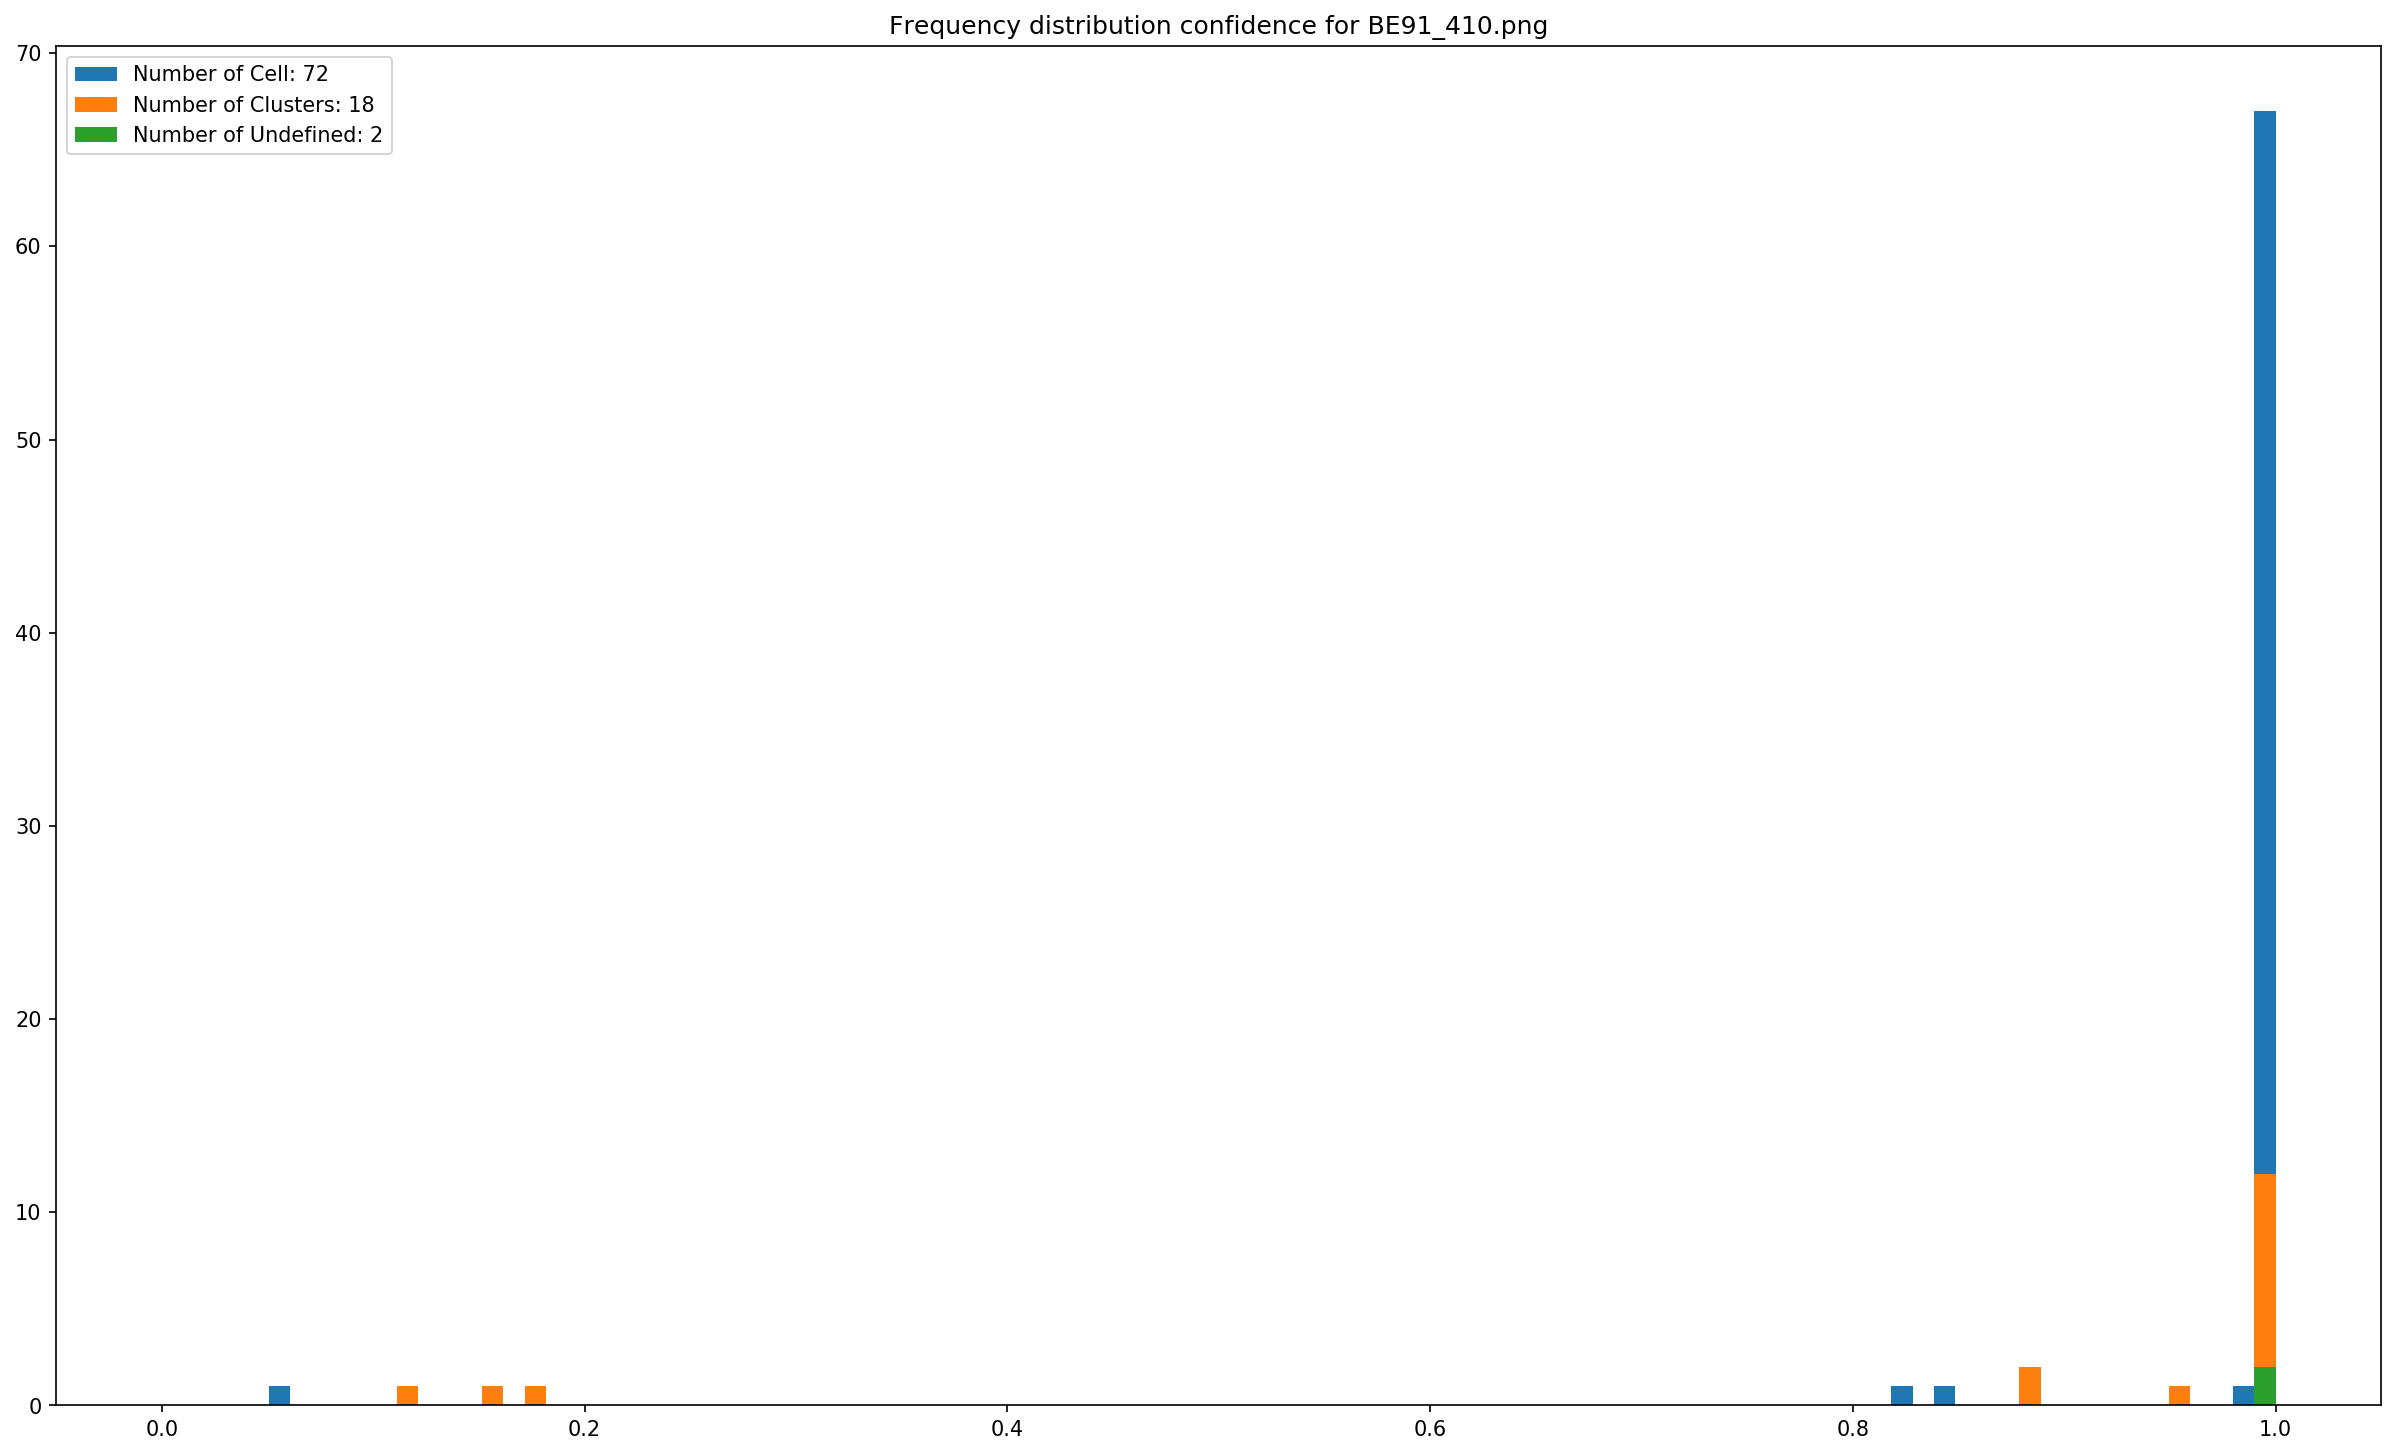

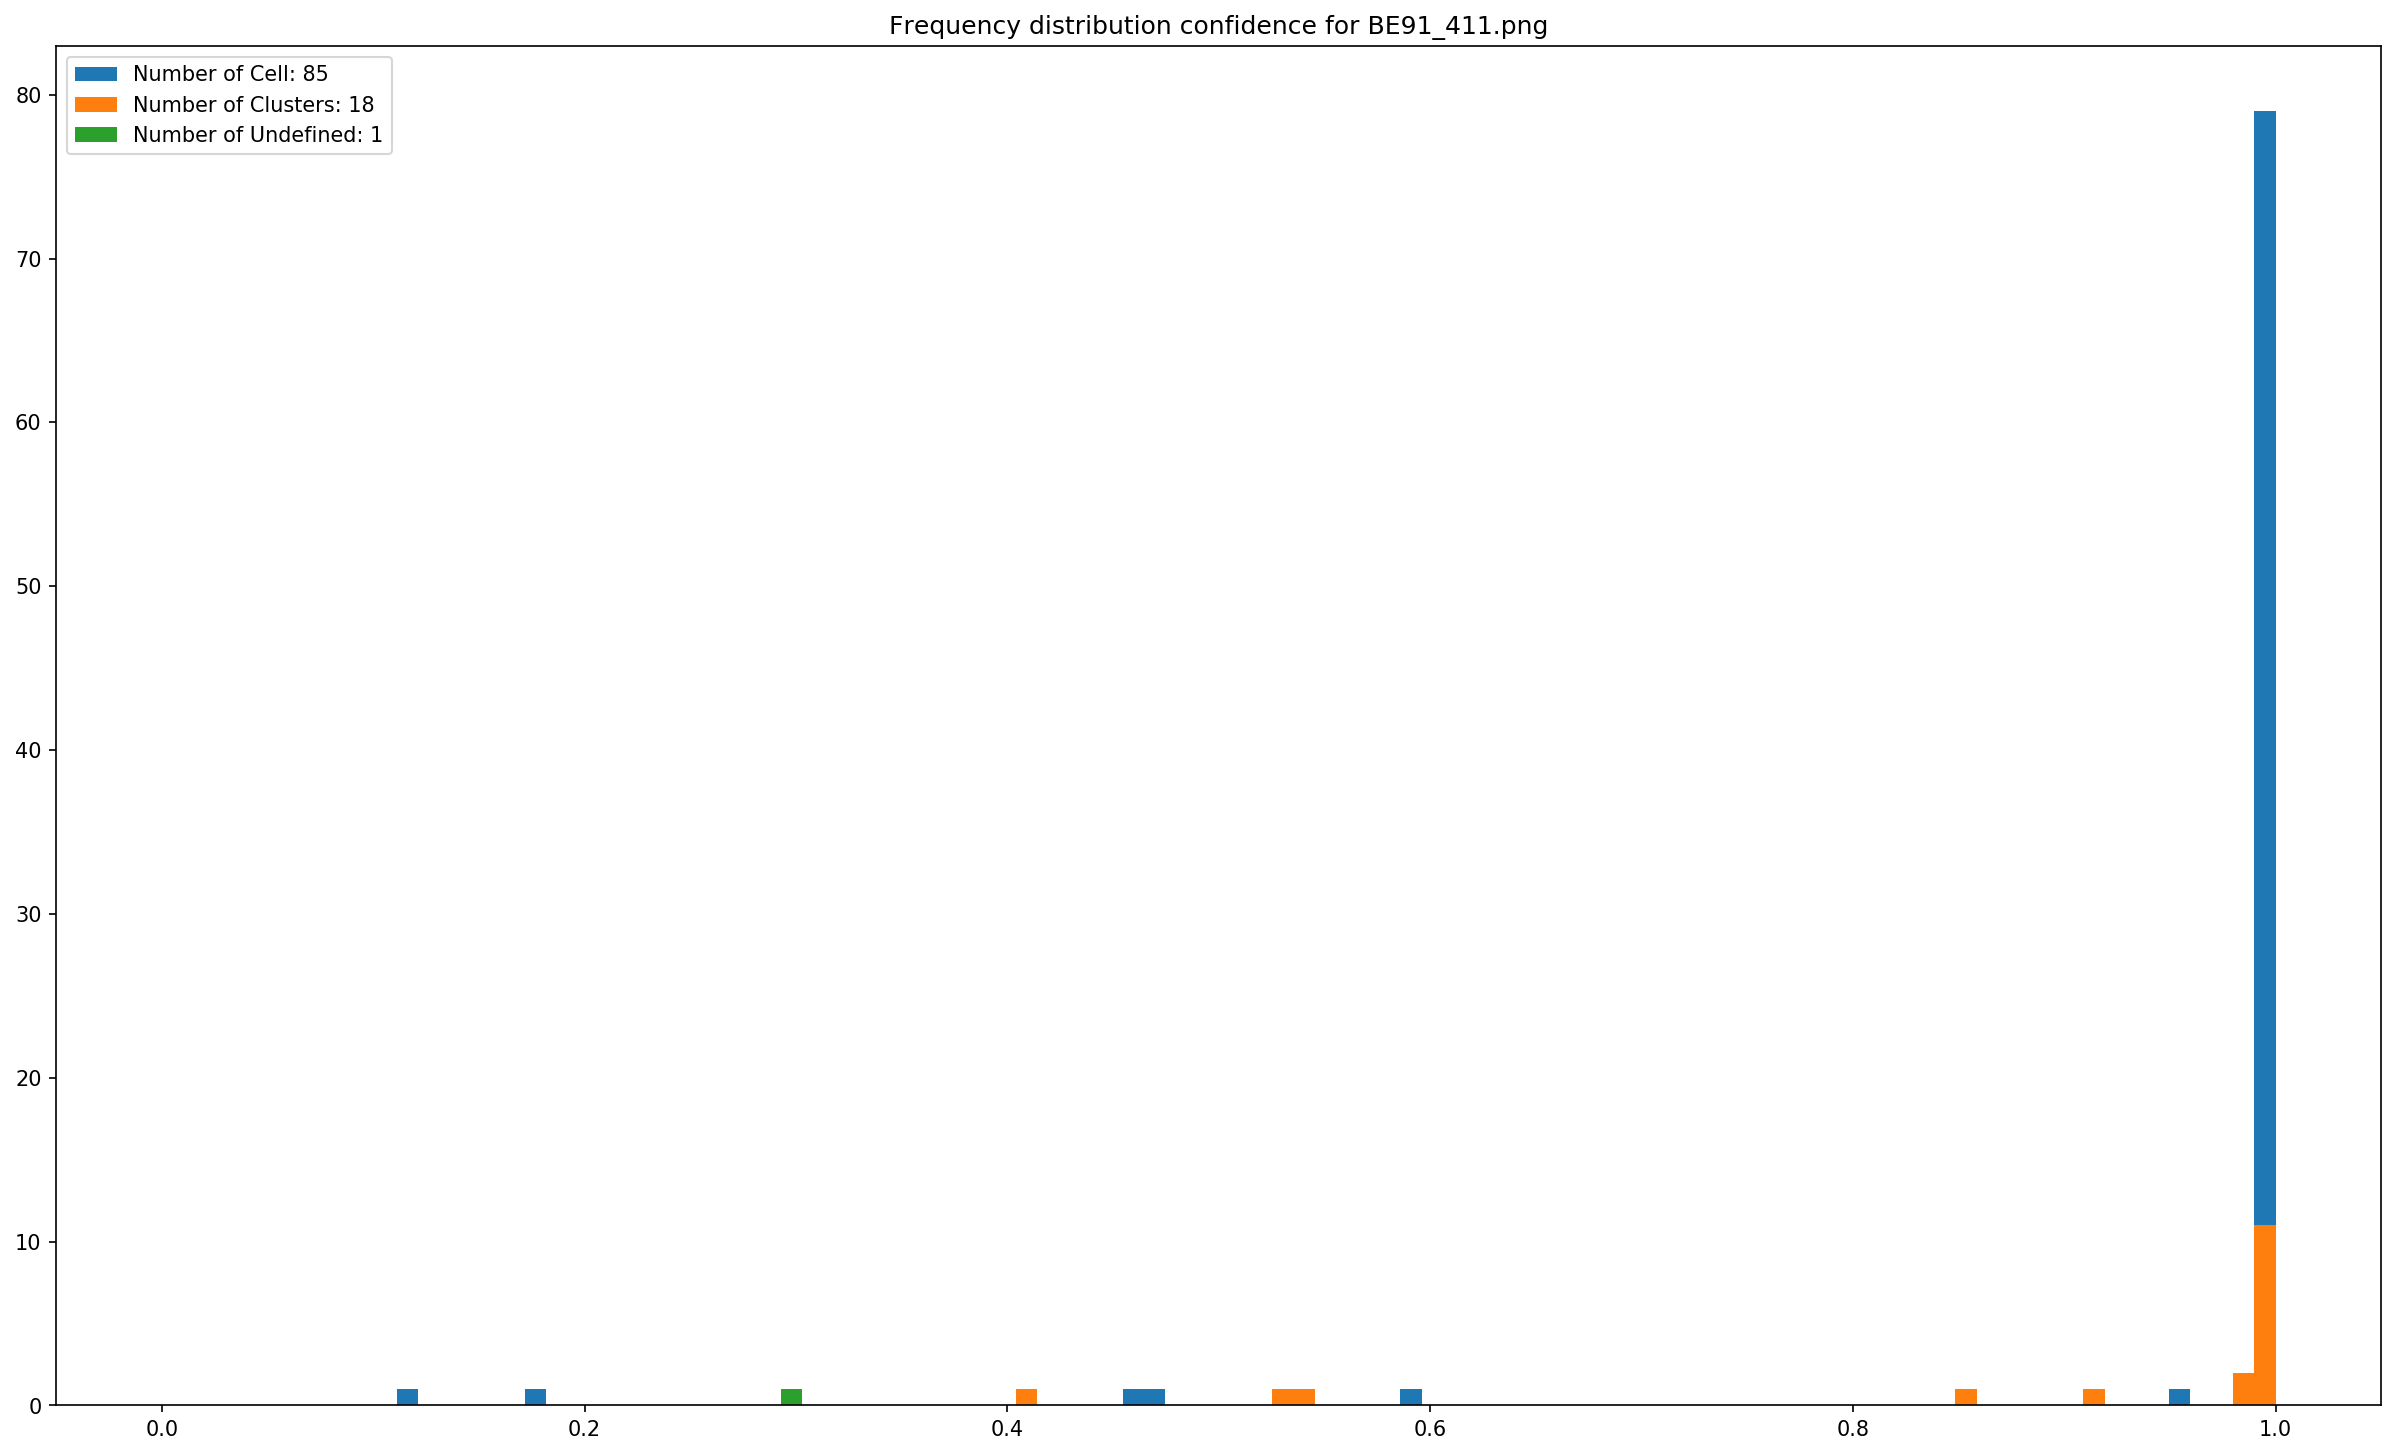

In [20]:
# plot confidence scores from the prediction
# save path to where the histograms should be saved
result_path = '/data/proj/smFISH/Students/Max_Senftleben/files/results/20190318_poly_t/'

def histo():
    
    for file_name in predictions:

        scores = predictions[file_name].get_field("scores").tolist()
        labels = predictions[file_name].get_field("labels").tolist()
        labels = [categories_to_pass[i] for i in labels]
        histogram(file_name, scores, labels, save_path = result_path)
histo()

In [46]:
# make result pdf with the ground truth, the masks, the bounding boxes and the confidence histogram
# in the result path should be saved the ground truth with ending _trut.png, the histogram with ending _hist.png
# the masks with ending _mask.png and the bounding boxes with ending _bbox.png

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter,A4
from reportlab.platypus import SimpleDocTemplate,Table,PageBreak, Paragraph, Spacer, Image
from reportlab.lib.units import inch
from reportlab.lib.enums import TA_RIGHT
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.styles import ParagraphStyle

def pdf(result_path, pdf_save_path, title):
    
    styles = getSampleStyleSheet()
    style_right = ParagraphStyle(name='right', parent=styles['Normal'], alignment=TA_RIGHT)
    doc = SimpleDocTemplate(pdf_save_path, topMargin=10)
    Story = []

    # specify title
    Story.append(Paragraph(title, styles['Title']))
    
    a=4
    b=4
    c=3
    print(c)

    
    
    image_names = set([i[:-9] for i in os.listdir(result_path)])
    for image in image_names:
        tb_data_line1 = [[ 
                Image(result_path + image + '_trut.png',a*inch, a*inch,hAlign="MIDDLE"),
                Image(result_path + image + '_mask.png',   a*inch, a*inch,hAlign="LEFT")
                ]]
        tb1 = Table(tb_data_line1)
        Story.append(tb1)
        
        tb_data_line2 = [[ 
                Image(result_path + image + '_bbox.png',a*inch, b*inch,hAlign="RIGHT"),
                Image(result_path + image + '_hist.png',   b*inch, c*inch,hAlign="LEFT")
                ]]
        tb2 = Table(tb_data_line2)
        Story.append(tb2)
        
        Story.append(PageBreak())
    doc.build(Story)
    
        

In [47]:
#

pdf(result_path, '/home/max/github/ms2/poly_t_152_535000.pdf', 'Poly-A')

3
